# Terrain Classification
### Created by Keenan McConkey 2019.5.17

In [1]:
from __future__ import absolute_import, division, print_function

import pandas as pd

import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from scipy import stats

from datetime import datetime
from decimal import Decimal

import pymrmr
import sklearn

## Part 1 - Importing Datasets

### Part (0) - Functions for Data Import

In [2]:
# Easier to read column names
std_columns = ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Run Time', 'Epoch Time']
data_columns =  ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro']
synthesis_columns = ['Calc X Accel', 'Calc X Vel', 'Calc Z Gyro', 'Run Time', 'Epoch Time']

# Number of columns containing directional data
N_DATA_COL = 6

# Columns not currently used
unused_columns = ['Time Received', 'Timestamp', 'Pitch (Deg)', 'Roll (Deg)', 'Heading (Deg)',
                  'L ACCELEROMETER X (m/s²)', 'L ACCELEROMETER Y (m/s²)', 'L ACCELEROMETER Z (m/s²)',
                  'L GYROSCOPE X (rad/s)', 'L GYROSCOPE Y (rad/s)', 'L GYROSCOPE Z (rad/s)',
                  'R ACCELEROMETER X (m/s²)', 'R ACCELEROMETER Y (m/s²)', 'R ACCELEROMETER Z (m/s²)',
                  'R GYROSCOPE X (rad/s)', 'R GYROSCOPE Y (rad/s)', 'R GYROSCOPE Z (rad/s)',
                  'ACCELEROMETER XY (m/s²)']

'''Get columns for given label'''
def get_columns(_label):
    
    # Columns are different for synthesis data
    if 'Middle' in _label or 'Left' in _label or 'Right' in _label:
        columns = std_columns.copy()
    
    # For transformed datasets replace time columns with frequency
    if 'FFT' in _label or 'PSD' in _label:
        columns.remove('Epoch Time')
        
        if 'Run Time' in columns:
            columns.remove('Run Time')
        
        columns.append('Frequency')
        
    return columns

In [3]:
# Types of terrains, placements, and transforms used
terrains = ['Concrete', 'Carpet', 'Linoleum', 'Asphalt', 'Sidewalk', 'Grass', 'Gravel']
placements = ['Left', 'Right', 'Middle']
transforms = ['FFT', 'PSD', 'PSDLog']

'''Get the integer terrain value of a given label'''
def get_terrain_num(_label):
    for i, terrain in enumerate(terrains):
        if terrain in _label:
            return i
        
    raise Exception('Unknown terrain')

'''Get the name associated with a terrain integer'''
def get_terrain_name(terrain_num):
    return terrains[terrain_num]

'''Get the placement location name for given label'''
def get_placement(_label):
    for placement in placements:
        if placement in _label:
            return placement
    
    raise Exception('Unknown placement')

'''Get the transform used for given label'''
def get_transform(_label):
    for transform in transforms:
        if transform in _label:
            return transform
    
    raise Exception('Unkown transform')

### Part (a) - Parsing Data into Pandas

In [4]:
# Find .csv files
raw_datasets = {}
dataset_labels = []
dataset_paths = glob.glob('imu_data/set_upgraded_manual/*_*Mahsa_*.csv')

# Remove synthesis and 9250 IMU data (for now)
for path in dataset_paths.copy():
    if 'Synthesis' in path or '9250' in path:
        dataset_paths.remove(path)

In [5]:
# Import datasets as a dictionary of Pandas DataFrames
for dataset_path in dataset_paths:
    
    # Parse labels from filenames
    dataset_label = dataset_path.split('/')[-1].split('.')[0]    
    dataset_labels.append(dataset_label)

    # Read from CSV to Pandas
    dataset = pd.read_csv(dataset_path)

    # Drop unused columns
    unused = [unused_column for unused_column in unused_columns if unused_column in dataset.columns]
    dataset = dataset.drop(unused, axis='columns')

    # Rename columns to something easier to work with
    dataset.columns = get_columns(dataset_label)

    # Convert timestamps to epoch time in s
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.strptime, args=("%Y-%m-%d %H:%M:%S:%f", ))
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.timestamp)
    
    # Remove gravitational acceleration from Middle data
    ## Can't remove from wheel-mounted Left and Right data because they rotate over time
    if 'Middle' in dataset_label:
        # Remove gravity from z component of acceleration, 
        g_z = 9.81
        dataset['Z Accel'] = dataset['Z Accel'].apply(lambda x: x - g_z)

    # Remove dropped bytes - i.e. run times below zero
    #dataset = dataset.drop(dataset.loc[dataset['Run Time'] < 0].index.values.tolist())

    # Trim edges to account for start and end time
    STARTUP_THRESH = 2.0
    # First instance above threshold
    start_index = dataset[dataset['Z Accel'] > STARTUP_THRESH].index[0]
    # Last instance above threshold
    stop_index = dataset[dataset['Z Accel'] > STARTUP_THRESH].index[-1]
    
    dataset = dataset[start_index:stop_index]
    
    # Datasets are stored in a dictionary
    raw_datasets.update({dataset_label: dataset})

In [6]:
# List all datasets
dataset_labels

['Left_GrassF8Mahsa_Module',
 'Middle_LinoleumF8Mahsa_Module6050',
 'Right_GrassStraightMahsa_Module',
 'Left_ConcreteF8Mahsa_Module',
 'Middle_GravelF8Mahsa_Module6050',
 'Left_GrassStraightMahsa_Module',
 'Right_GrassDonutMahsa_Module',
 'Left_LinoleumDonutMahsa_Module',
 'Right_ConcreteDonutMahsa_Module',
 'Right_SidewalkDonutMahsa_Module',
 'Middle_AsphaltStraightMahsa_Module6050',
 'Right_LinoleumDonutMahsa_Module',
 'Right_SidewalkF8Mahsa_Module',
 'Middle_SidewalkStraightMahsa_Module6050',
 'Middle_SidewalkDonutMahsa_Module6050',
 'Left_ConcreteStraightMahsa_Module',
 'Middle_GrassF8Mahsa_Module6050',
 'Middle_ConcreteF8Mahsa_Module6050',
 'Right_LinoleumF8Mahsa_Module',
 'Middle_CarpetDonutMahsa_Module6050',
 'Middle_ConcreteDonutMahsa_Module6050',
 'Middle_AsphaltF8Mahsa_Module6050',
 'Left_SidewalkDonutMahsa_Module',
 'Right_CarpetDonutMahsa_Module',
 'Right_CarpetF8Mahsa_Module',
 'Left_ConcreteDonutMahsa_Module',
 'Right_AsphaltStraightMahsa_Module',
 'Left_AsphaltF8Mahsa_M

In [7]:
# Check dataset formatting
raw_datasets[dataset_labels[0]].head()

X Accel   Y Accel   Z Accel    X Gyro    Y Gyro    Z Gyro  Run Time  \
3496 -8.835595  4.680302  2.083045 -0.054910  0.038337 -0.057237    10.490   
3497 -9.747772  4.364272  0.857232 -0.054377  0.029548 -0.060167    10.493   
3498 -9.279712  3.887833 -0.658274 -0.044257  0.044462 -0.053509    10.496   
3499 -9.790867  3.606519 -1.433984 -0.017892  0.080148 -0.044721    10.499   
3500 -9.493990  3.173175 -1.073662 -0.007239  0.051120 -0.046851    10.502   

        Epoch Time  
3496  1.564696e+09  
3497  1.564696e+09  
3498  1.564696e+09  
3499  1.564696e+09  
3500  1.564696e+09

### Part (b) - Visualizing Time Domain Data

In [8]:
'''Plot a single dataset in one direction'''
def plot_one(_datasets, dataset_name, x_axis, y_axis, xlim=None, ylim=None, save_fig=False):
    plt.clf()
    plt.figure(figsize=(10, 5))
    
    plt.plot(_datasets[dataset_name][x_axis], _datasets[dataset_name][y_axis])
    plt.title(dataset_name)
    plt.xlabel(x_axis + ' (s)')
    
    if 'Accel' in y_axis:
        plt.ylabel(y_axis + ' ($m/s^2$)')
    elif 'Gyro' in y_axis:
        plt.ylabel(y_axis + ' ($rad/s$)')
    else:
        plt.ylabel('Unknown')
    
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    
    # Save figure to png file without plotting
    if save_fig:
        save_name = '/home/caris/Wheelchair-Terrain-Classification/imgs/'
        save_name = save_name + y_axis.replace(' ', '_') + '_' + dataset_name + '.png'
        plt.savefig(save_name)
    
    # Just plot without saving
    else:    
        plt.show()

<Figure size 432x288 with 0 Axes>

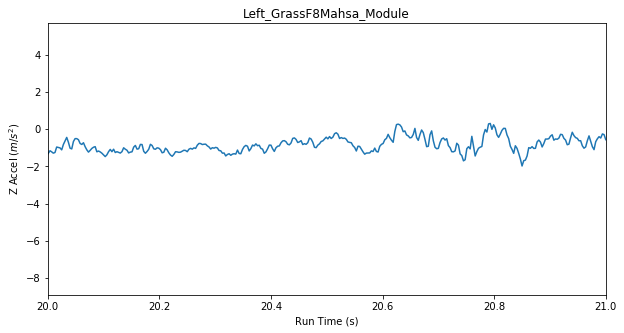

In [9]:
# Plot some raw data
plot_one(raw_datasets, dataset_labels[0], 'Run Time', 'Z Accel', xlim=(20, 21))

In [10]:
# Plot every dataset Z Accel and save images
#for label in dataset_labels:
#    plot_one(raw_datasets, label, 'Run Time', 'Z Accel', save_fig=True)

In [11]:
'''Compare two Pandas DataFrames by Epoch Time'''
def dataset_compare(dataset1, label1, dataset2, label2, dirn, t_offset=0, y_offset=0):
    plt.clf()
    fig, ax = plt.subplots(figsize=(20, 5))
    
    # Plot data with given y and t offsetson first dataset
    ax.plot(dataset1[label1]['Epoch Time'].apply(lambda t: t + t_offset), 
            dataset1[label1][dirn].apply(lambda y: y + y_offset), label=label1)
    ax.plot(dataset2[label2]['Epoch Time'], 
            dataset2[label2][dirn], label=label2)
    
    ax.set_xlabel('Epoch Time ($s$)')
    if 'Gyro' in dirn:
        ax.set_ylabel(dirn + ' ($rad/s$)')
    elif 'Accel' in dirn:
        ax.set_ylabel(dirn + ' ($m/s^2$)')
    
    ax.set_title(dirn + ' for ' + label1 + ' and ' + label2)
    
    # Plot offset info
    offset_text = 'Offsets\n'
    offset_text += ': t={}'.format(t_offset) + ', ' + 'y={}'.format(y_offset)
    ax.text(0.05, 0.05, s=offset_text, 
            horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
    
    ax.legend()
    plt.show()

<Figure size 432x288 with 0 Axes>

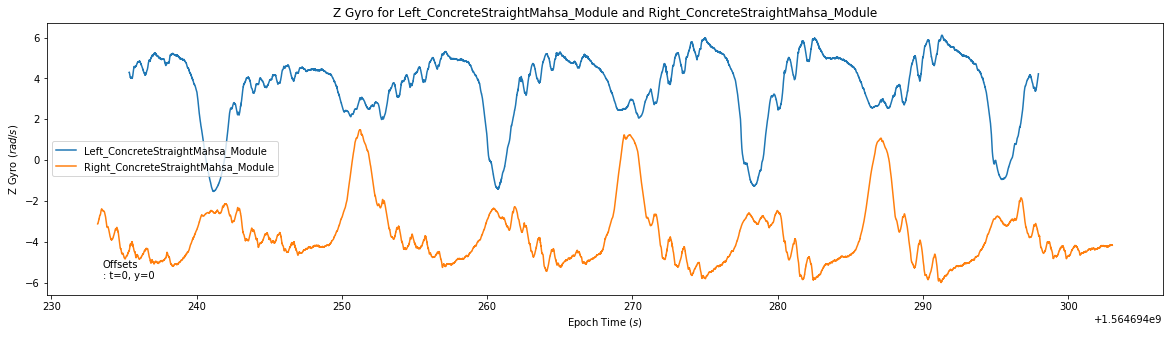

In [13]:
# Compare Z Gyro data for each wheel in the same dataset
dataset_compare(raw_datasets, 'Left_ConcreteStraightMahsa_Module',
                raw_datasets, 'Right_ConcreteStraightMahsa_Module', 
                dirn='Z Gyro')

In [14]:
'''Plot given x and y axes for every Pandas DataFrame in given array of datasets'''
def plot_all(_datasets, x_axis, y_axis, windowed=False, win_num=0, take_row=False):
    plt.clf()
    
    n_axes = len(_datasets)
    odd_axes = n_axes % 2 == 1
    
    rows = int((n_axes + 1) / 2)
    
    # Scale approriately
    if (odd_axes):
        fig = plt.figure(figsize=(n_axes*5, n_axes*3))          
    else:
        fig = plt.figure(figsize=(n_axes*5, n_axes*2))
    
    # Grid of subplots
    gs = gridspec.GridSpec(rows, 2)
        
    axes = []
    row, col = 0, 0
    
    for i, (label, dataset) in enumerate(_datasets.items()):
        # Take a whole row if odd num of axes
        if (i == n_axes-1 and odd_axes and take_row): 
            axes.append(fig.add_subplot(gs[row, :]))
        else:
            axes.append(fig.add_subplot(gs[row, col]))
        
        # Plot on new subplot
        if (windowed):
            axes[i].plot(dataset[win_num][x_axis], dataset[win_num][y_axis])
        else:
            axes[i].plot(dataset[x_axis], dataset[y_axis])
        
        axes[i].set_title(label)
        axes[i].set_xlabel(x_axis + ' (s)')
        
        if 'Gyro' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($rad/s$)')
        elif 'Accel' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($m/s^2$)')
        
        # Only go two columns wide
        col += 1
        if (col == 2):
            row += 1
            col = 0
        
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    plt.show()

<Figure size 432x288 with 0 Axes>

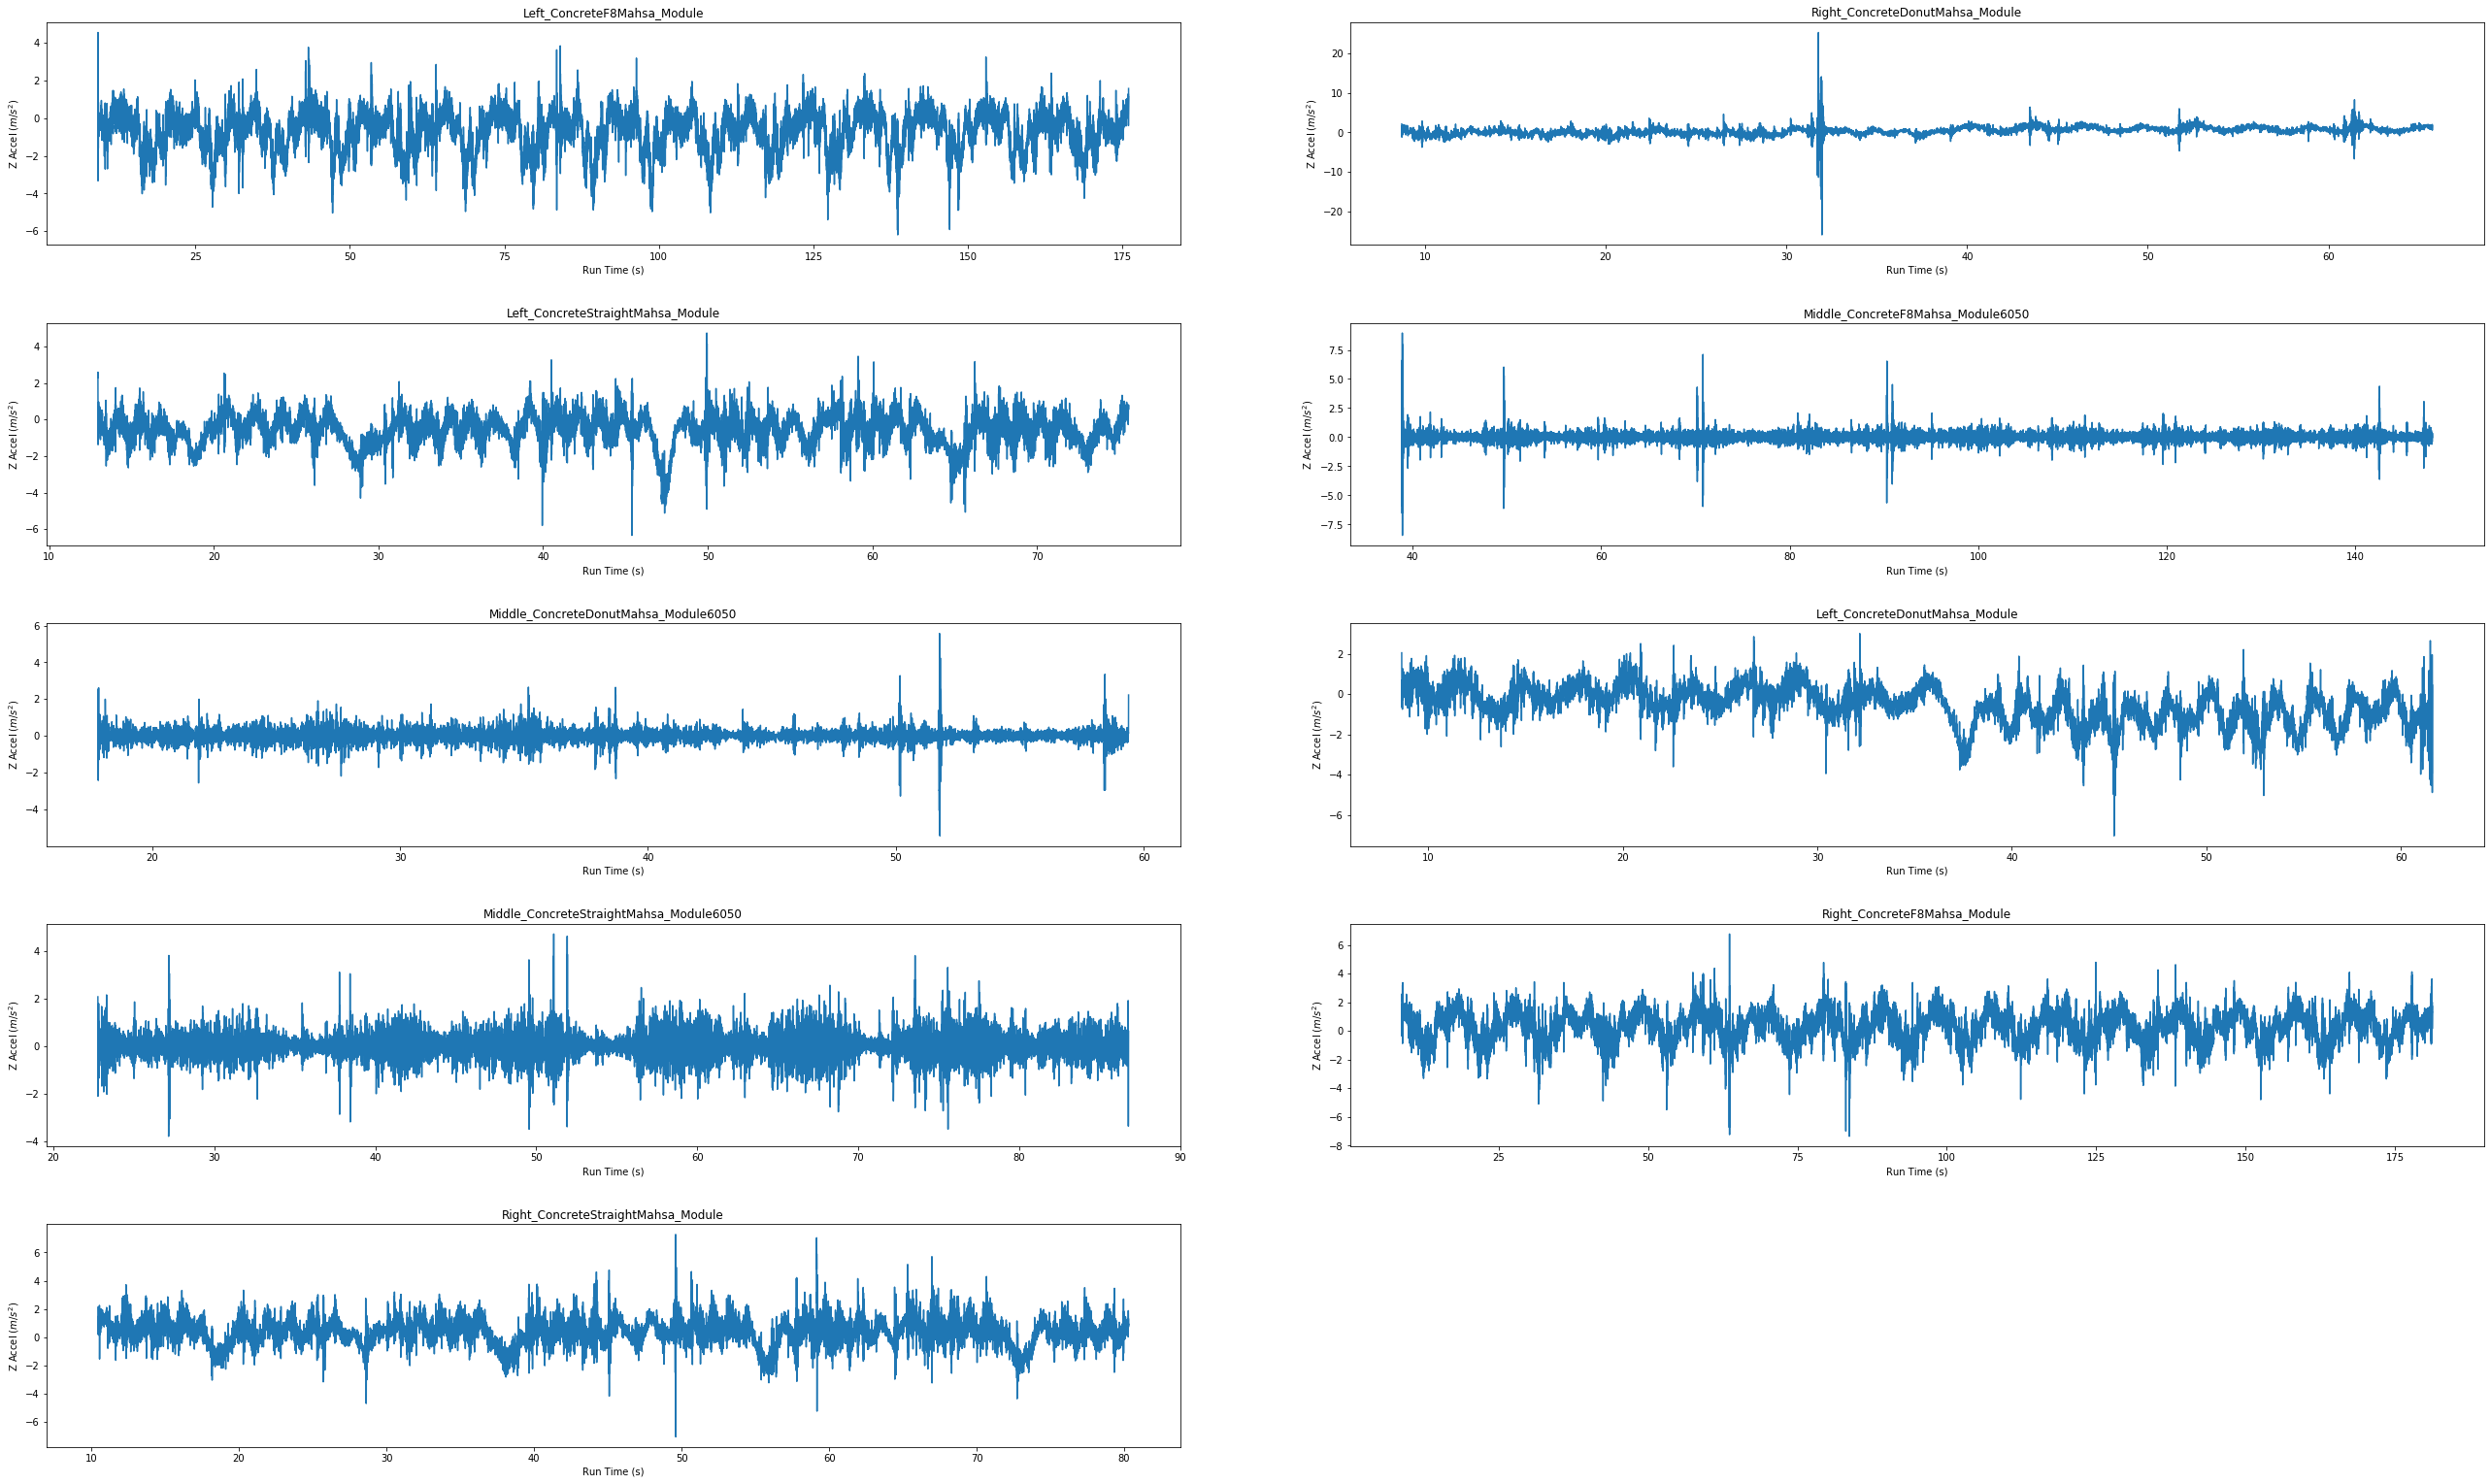

In [15]:
# Plot Z Accel of same dataset for different modules
datasets_to_plot = {label: dataset for label, dataset in raw_datasets.items() if 'Concrete' in label}
plot_all(datasets_to_plot, x_axis='Run Time', y_axis='Z Accel')

### Part (c) - Converting Between Pandas and Numpy

In [16]:
'''Convert array of Pandas DataFrames to array of 2D Numpy array'''
def pd_to_np(pd_datasets, windowed=False):
    np_datasets = {}
    
    for label, dataset in pd_datasets.items():
        np_dataset = []
        
        # Return passed datasets if they are already NumPy ndarrays
        if type(dataset) is np.ndarray:
            print('Note: Already a NumPy array!')
            return pd_datasets
        
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                np_dataset.append(window.as_matrix()) 
        else:
            np_dataset = dataset.to_numpy()
        
        np_datasets.update({label: np_dataset})
        
    return np_datasets

In [17]:
'''Convert array of 2D Numpy arrays to Pandas Data Frames'''
def np_to_pd(np_datasets, windowed=False):
    pd_datasets = {}
    
    for label, dataset in np_datasets.items():
        pd_dataset = []
        
        # Return passed datasets if they are already Pandas dataframes
        if type(dataset) is pd.DataFrame:
            print('Note: Already a Pandas dataframe!')
            return np_datasets
        
        # Use correct column names
        new_columns = get_columns(label)
            
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                pd_dataset.append(pd.DataFrame(data=window, columns=new_columns))
                
        else:
            pd_dataset = pd.DataFrame(data=dataset, columns=new_columns)
            
        pd_datasets.update({label: pd_dataset})
    
    return pd_datasets

In [18]:
# Convert to NumPy
raw_datasets = pd_to_np(raw_datasets)

In [19]:
# Run to convert back to Pandas
#raw_datasets = np_to_pd(raw_datasets)

In [20]:
# Check if its constructed correctly
print('Number of datasets: {}'.format(len(raw_datasets)))
print('Shape of first dataset: {}'.format(raw_datasets[dataset_labels[0]].shape))

Number of datasets: 60
Shape of first dataset: (61131, 8)


#### Data Structure:

`Terrain Dataset Dictionary 
-> NP Array
---> Row = Datapoint, 
---> Col = Direction | Time`

## Part 2 - Filtering

**Nominally set to 30 % of Nyquist Freq**

In [21]:
'''Get relevant frequencies for given label based on whether its a frame or wheel dataset'''
def get_frequencies(label):
    # Sampling frequency (and thus cutoff frequency) varies between frame and wheel modules
    if 'Left' in label or 'Right' in label:
        f_samp = 333.3 # Sampling frequency
        f_low = 60 # Low pass cutoff frequency
        f_high = 1 # High pass cutoff frequency
    elif 'Middle' in label:
        f_samp = 300 # Sampling frequency
        f_low = 55 # Low pass cutoff frequency
        f_high = 1 # High pass cutoaff frequency
    else:
        raise Exception('Unknown label format')
        
    return f_samp, f_low, f_high

In [22]:
'''Get window size based on whether label is for a frame or wheel dataset'''
def get_window_size(label):
    if 'Left' in label or 'Right' in label:
        window_size = 333
    elif 'Middle' in label:
        window_size = 300
    else:
        raise Exception('Unknown label format')
    return window_size

### Part (a) - Butterworth Filtering

Butterworth filters can be high-pass/low-pass/bandpass, and attempt to have maximally flat frequency response in bandpass.

Changing the *cutoff frequency* of the filter affects the smoothness of the graph and amount of ringing. 

Changing the *order* of the filter can have significant effects on smoothness depending on the cutoff frequency. 

In [23]:
# Filtered datasets dictionary
datasets = {}

for label, raw_dataset in raw_datasets.items():
    
    # Sampling rates are not consistent across all datasets
    f_samp, f_low, f_high = get_frequencies(label)
    
    # Get normalized frequencies
    w_low = f_low / (f_samp / 2) 
    w_high = f_high / (f_samp / 2)

    # Get Butterworth filter parameters
    b_butter, a_butter = signal.butter(N=4, Wn=w_low, btype='low')
    
    # Filter all the data columns
    dataset = np.copy(raw_dataset)
    for i in range(N_DATA_COL):
        dataset[:, i] = signal.filtfilt(b_butter, a_butter, raw_dataset[:, i])
        
    datasets.update({label: dataset})

<Figure size 432x288 with 0 Axes>

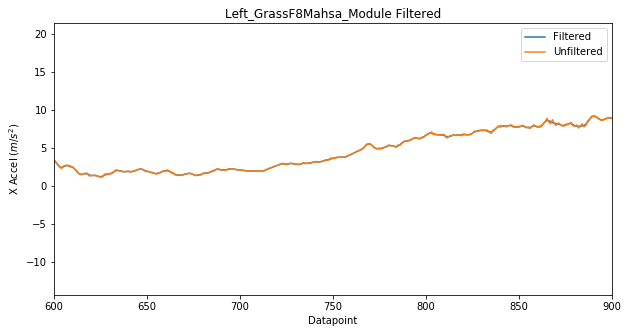

In [24]:
# Compare filtered and unfiltered
plt.clf()
plt.figure(figsize=(10, 5))
plt.plot(datasets[dataset_labels[0]][:, 0], label='Filtered')
plt.plot(raw_datasets[dataset_labels[0]][:, 0], label='Unfiltered')
plt.xlim(600, 900)
plt.legend()
plt.xlabel('Datapoint')
plt.ylabel('X Accel ($m/s^2$)')
plt.title(dataset_labels[0] + ' Filtered')
plt.show()

In [25]:
## Check construction
print('Num filtered datasets: {}'.format(len(datasets)))
print('Shape of first filtered dataset: {}'.format(datasets[dataset_labels[0]].shape))

Num filtered datasets: 60
Shape of first filtered dataset: (61131, 8)


In [26]:
# Verify we can convert back to Pandas
np_to_pd(datasets, windowed=False)[dataset_labels[0]].head()

X Accel   Y Accel   Z Accel    X Gyro    Y Gyro    Z Gyro  Run Time  \
0 -8.835735  4.680273  2.082295 -0.054907  0.038334 -0.057236    10.490   
1 -9.342328  4.328251  0.544652 -0.047811  0.048677 -0.054976    10.493   
2 -9.611139  3.920231 -0.637479 -0.038281  0.057063 -0.051884    10.496   
3 -9.595030  3.495905 -1.193697 -0.026385  0.056670 -0.048913    10.499   
4 -9.450928  3.199224 -1.067828 -0.012621  0.042131 -0.047560    10.502   

     Epoch Time  
0  1.564696e+09  
1  1.564696e+09  
2  1.564696e+09  
3  1.564696e+09  
4  1.564696e+09

<Figure size 432x288 with 0 Axes>

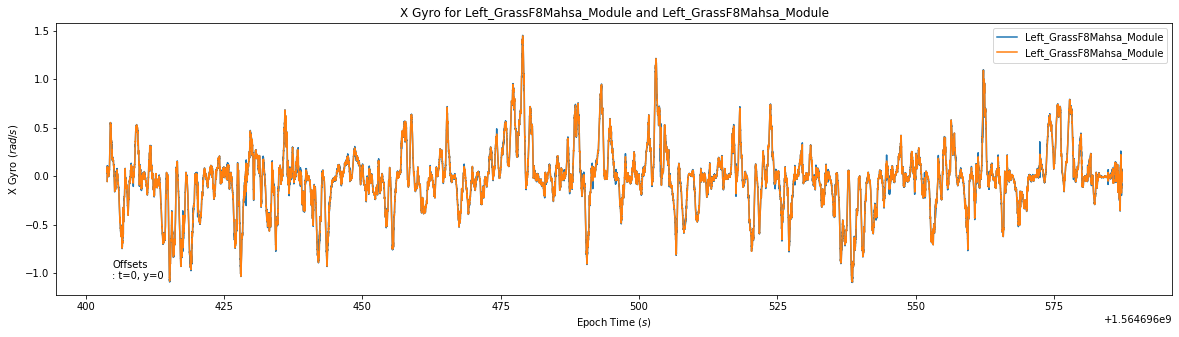

In [27]:
# Again compare filtered and unfiltered data
dataset_compare(np_to_pd(raw_datasets), dataset_labels[0], 
                np_to_pd(datasets), dataset_labels[0], 'X Gyro')

### Part (b) - Further Time Domain Visualization

In [28]:
'''Compare Z Gyro of frame to calculated value off of two wheels'''
def gyro_compare(dataset, label, xlim=None):
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Calculate Z Gyro off of wheels
    r_wheel = 0.30
    d_base = 0.54
    calc = (r_wheel / d_base)*(-1 * dataset['Left_' + label]['Z Gyro'] - dataset['Right_' + label]['Z Gyro'])
    calc = np.reshape(calc, dataset['Right_' + label]['Epoch Time'].shape)
    
    # Plot actual frame gyro, calculated frame gyro, and actual wheel gyro
    ax.plot(dataset['Middle_' + label]['Epoch Time'], dataset['Middle_' + label]['Z Gyro'], 
            label='Actual Frame')
    ax.plot(dataset['Right_' + label]['Epoch Time'], calc, label='Calculated Frame')
    ax.plot(dataset['Left_' + label]['Epoch Time'], dataset['Left_' + label]['Z Gyro'], 
            label='Actual L Wheel')
    ax.plot(dataset['Right_' + label]['Epoch Time'], dataset['Right_' + label]['Z Gyro'],
            label='Actual R Wheel')
    
    # Other figure stuff
    ax.set_xlabel('Epoch Time ($s$)')
    ax.set_ylabel('Z Gyro ($m/s^2$)')
    ax.set_title('Comparing Actual to Calculated Z Gyro Data')
    
    if xlim:
        start_time = dataset['Middle_' + label]['Epoch Time'][0]
        ax.set_xlim(xlim[0] + start_time, xlim[1] + start_time)
    ax.legend()
    plt.show()

In [29]:
#gyro_compare(np_to_pd(datasets), 'ConcreteDonutKevin_Module', xlim=(20, 40))

## Part 3 - Time Windows

### Part (a) - Creating Time Windowed Data

In [30]:
datasets_windowed = {}

# Trim excess datapoints, then split into windows
for label, dataset in datasets.items():
    window_size = get_window_size(label)
    n_windows = int(len(dataset) / window_size) # Note: Integer floor
    n_points = n_windows * window_size
    
    dataset_windowed = np.resize(dataset, (n_points, dataset.shape[1]))
    dataset_windowed = np.split(dataset_windowed, n_windows, axis=0)
    
    datasets_windowed.update({label: dataset_windowed})

In [31]:
# Check if its constructed correctly
print('Num windowed datasets: {}'.format(len(datasets_windowed)))
print('Num of windows in first dataset: {}'.format(len(datasets_windowed[dataset_labels[0]])))
print('Shape of individual window: {}'.format(datasets_windowed[dataset_labels[0]][0].shape))

Num windowed datasets: 60
Num of windows in first dataset: 183
Shape of individual window: (333, 8)


In [32]:
# Try out pandas conversion again
np_to_pd(datasets_windowed, windowed=True)[dataset_labels[0]][0].tail()

X Accel   Y Accel   Z Accel    X Gyro    Y Gyro    Z Gyro  Run Time  \
328 -4.378459  8.690957 -0.121042  0.171110 -0.497741  1.076440    11.474   
329 -4.375000  8.756888 -0.197662  0.171885 -0.501310  1.081360    11.477   
330 -4.410661  8.802419 -0.162995  0.169935 -0.510046  1.084993    11.480   
331 -4.427710  8.810112 -0.045559  0.168034 -0.518730  1.088127    11.483   
332 -4.361078  8.796074  0.060080  0.168769 -0.523620  1.091643    11.486   

       Epoch Time  
328  1.564696e+09  
329  1.564696e+09  
330  1.564696e+09  
331  1.564696e+09  
332  1.564696e+09

<Figure size 432x288 with 0 Axes>

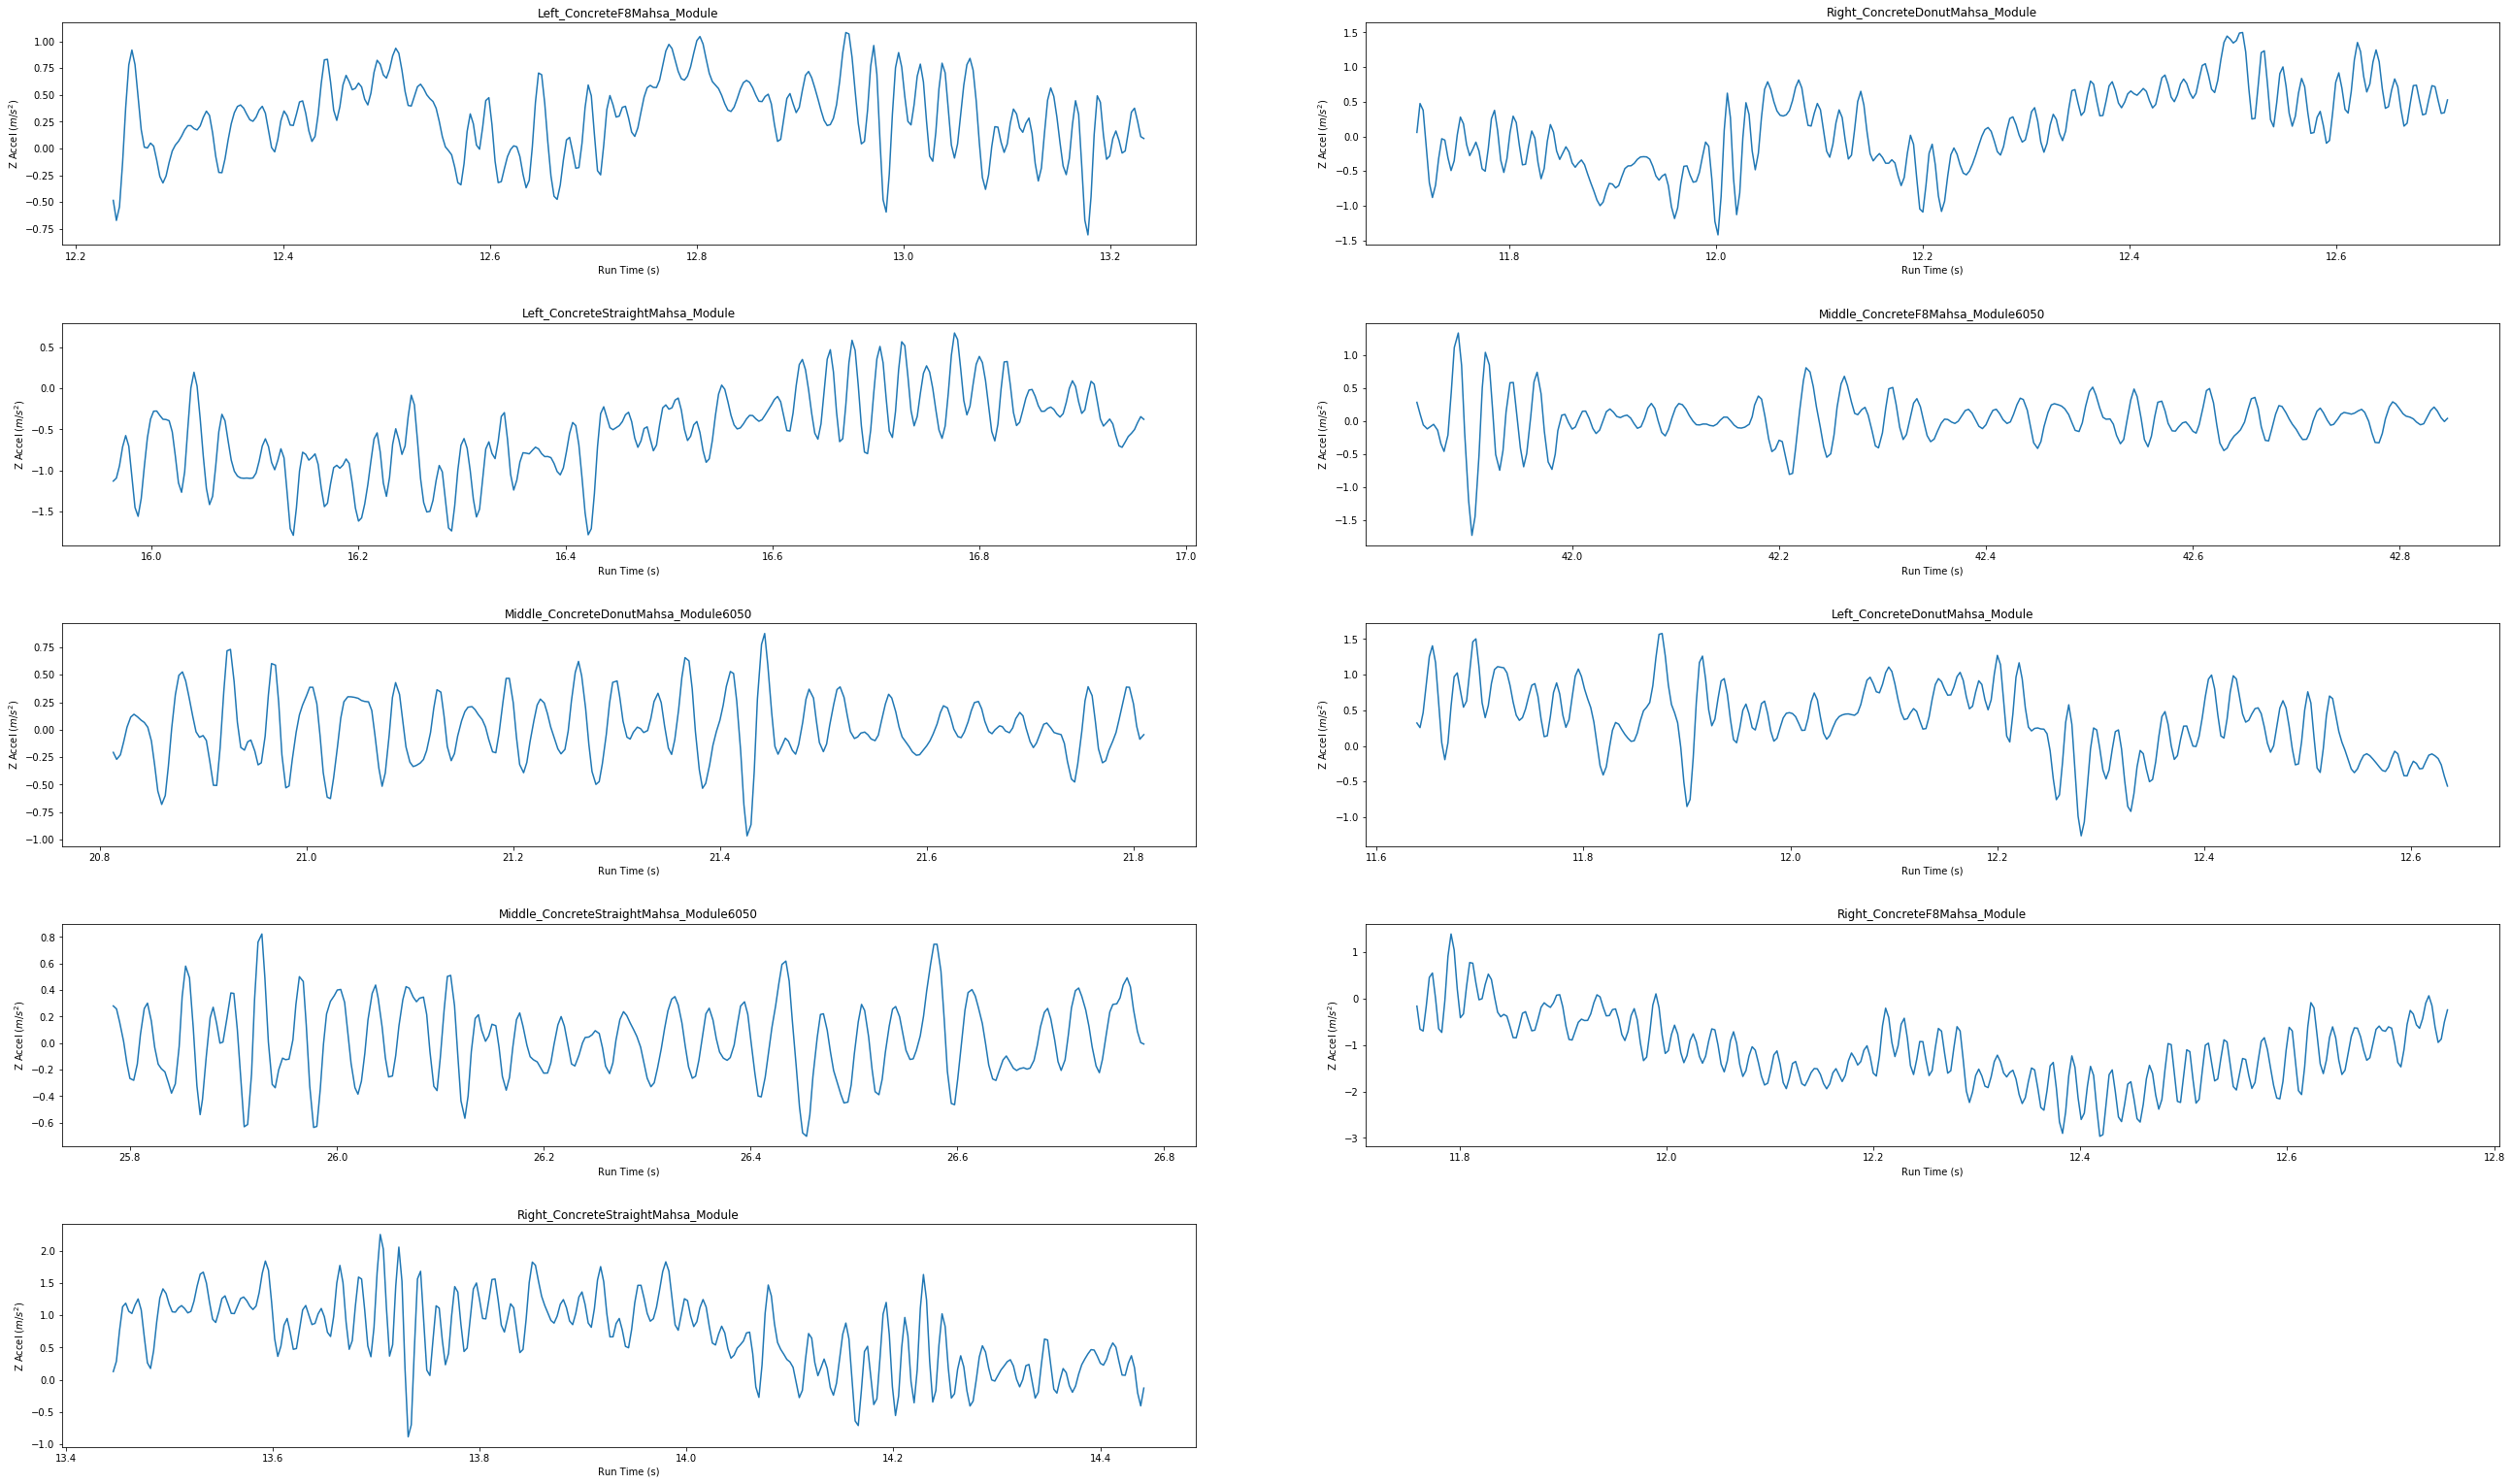

In [33]:
# Plot the first time window
datasets_to_plot = {label: dataset for label, dataset in datasets_windowed.items() if 'Concrete' in label}
plot_all(np_to_pd(datasets_to_plot, windowed=True), 
         x_axis='Run Time', y_axis='Z Accel', windowed=True, win_num=3)

#### Data Structure

`Terrain Dataset Dictionary
-> Data Window List
---> NP Array
-----> Row = Datapoint
-----> Col = Direction | Time`

## Part 4 - Transforms

In [34]:
'''Plot tranform of given direction and window of a windowed dataset dictionary'''
def plot_set_transforms(datasets_transformed, dirn, win_num, transform_name):
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Plot all the FFTs in one figure overlaid
    for label, dataset in datasets_transformed.items():
        plt.plot(dataset[win_num][:, -1], dataset[win_num][:, dirn], 
                 label=label)
    plt.legend()

    plt.xlabel('Frequency ($Hz$)')
    if (transform_name == 'FFT'):
        plt.ylabel('Amplitude (Normalized to Window Size)')
    elif (transform_name == 'PSD'):
        plt.ylabel('Amplitude (Log-Scaled)')

    plt.title(transform_name +' of ' + data_columns[dirn] + ', Window {}')
    plt.show()

### Part (a) - FFT

In [35]:
datasets_fft = {}
N_BINS_OVER_CUTOFF = 5 # Number of frequency bins past the cutoff frequency to include

# Find the FFT of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_fft = []
    
    for window in dataset:
        # Sampling frequency dependent on device
        f_samp, f_low, f_high = get_frequencies(label)
        
        # Only include frequency bins up to and a little bit past the cutoff frequency
        # Everything past that is useless because its the same on all terrains
        window_size = get_window_size(label)
        n_bins = int(window_size / f_samp * f_low) + N_BINS_OVER_CUTOFF
        window_fft = np.zeros((n_bins, N_DATA_COL))
        
        for i in range(N_DATA_COL):
            # FFT is normalized to window size, to ensure consistency between different size choices
            window_fft[:, i] = np.resize(np.abs(np.divide(np.fft.fft(window[:, i]), window_size)), n_bins)
            
        # Get positive frequency bins for given FFT parameters
        freq_col = np.transpose([np.resize(np.fft.fftfreq(window_size, 1 / f_samp), n_bins)])
        
        # Append the frequency column
        window_fft = np.append(window_fft, freq_col, axis=1)
        dataset_fft.append(window_fft)
        
    datasets_fft.update({label + 'FFT': dataset_fft})

In [36]:
# Check again if its constructed correctly
print('Num of FFT\'d windowed datasets: {}'.format(len(datasets_fft)))
print('Num of FFT\'d windows in first dataset: {}'.format(len(datasets_fft[dataset_labels[4]+'FFT'])))
print('Shape of FFT\'d individual window: {}'.format(datasets_fft[dataset_labels[4]+'FFT'][0].shape))

# Pandas conversion
np_to_pd(datasets_fft, windowed=True)[dataset_labels[0]+'FFT'][0].head()

Num of FFT'd windowed datasets: 60
Num of FFT'd windows in first dataset: 183
Shape of FFT'd individual window: (60, 7)


X Accel   Y Accel   Z Accel    X Gyro    Y Gyro    Z Gyro  Frequency
0  7.991159  5.698948  0.591486  0.221206  0.331437  0.740337   0.000000
1  1.190386  1.397246  0.095173  0.121146  0.178917  0.373169   1.000901
2  0.470294  0.345796  0.095448  0.036238  0.037985  0.061732   2.001802
3  0.304004  0.237403  0.037030  0.019364  0.031517  0.059455   3.002703
4  0.237343  0.192120  0.005010  0.005392  0.011987  0.042085   4.003604

<Figure size 432x288 with 0 Axes>

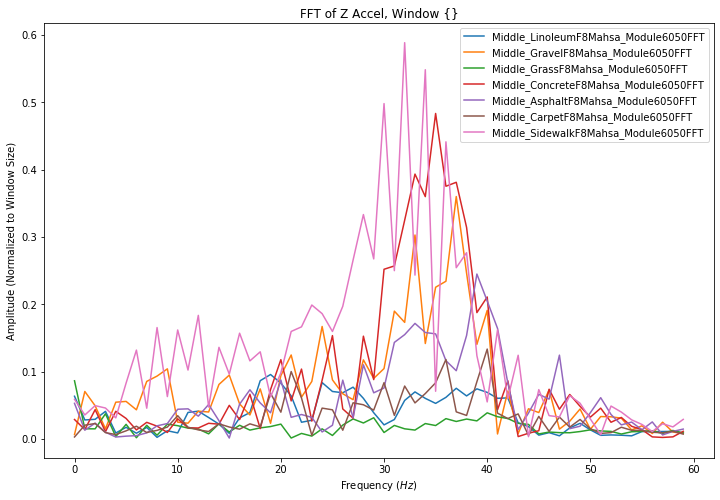

In [40]:
# Plot Middle Z Accel of 10th window
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(ffts_to_plot, win_num=0, dirn=2, transform_name='FFT')

<Figure size 432x288 with 0 Axes>

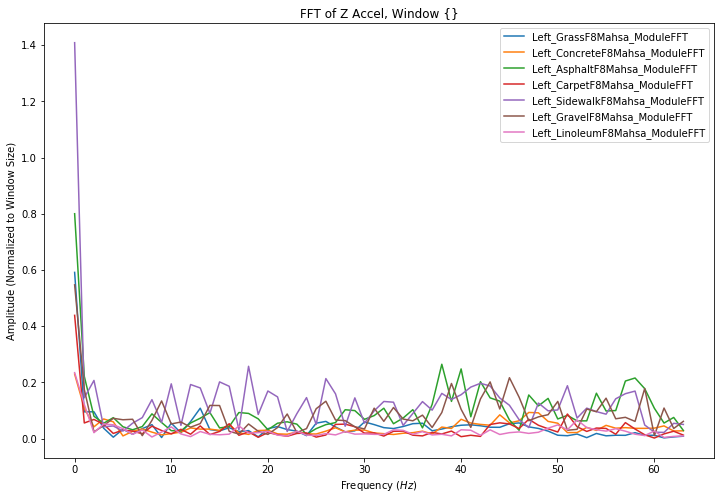

In [41]:
# Plot Left Z Accel of 10th window
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Left' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(ffts_to_plot, win_num=0, dirn=2, transform_name='FFT')

**The number of frequency bins is dependent on window size, and it seems to affect amplitude too.**

<Figure size 432x288 with 0 Axes>

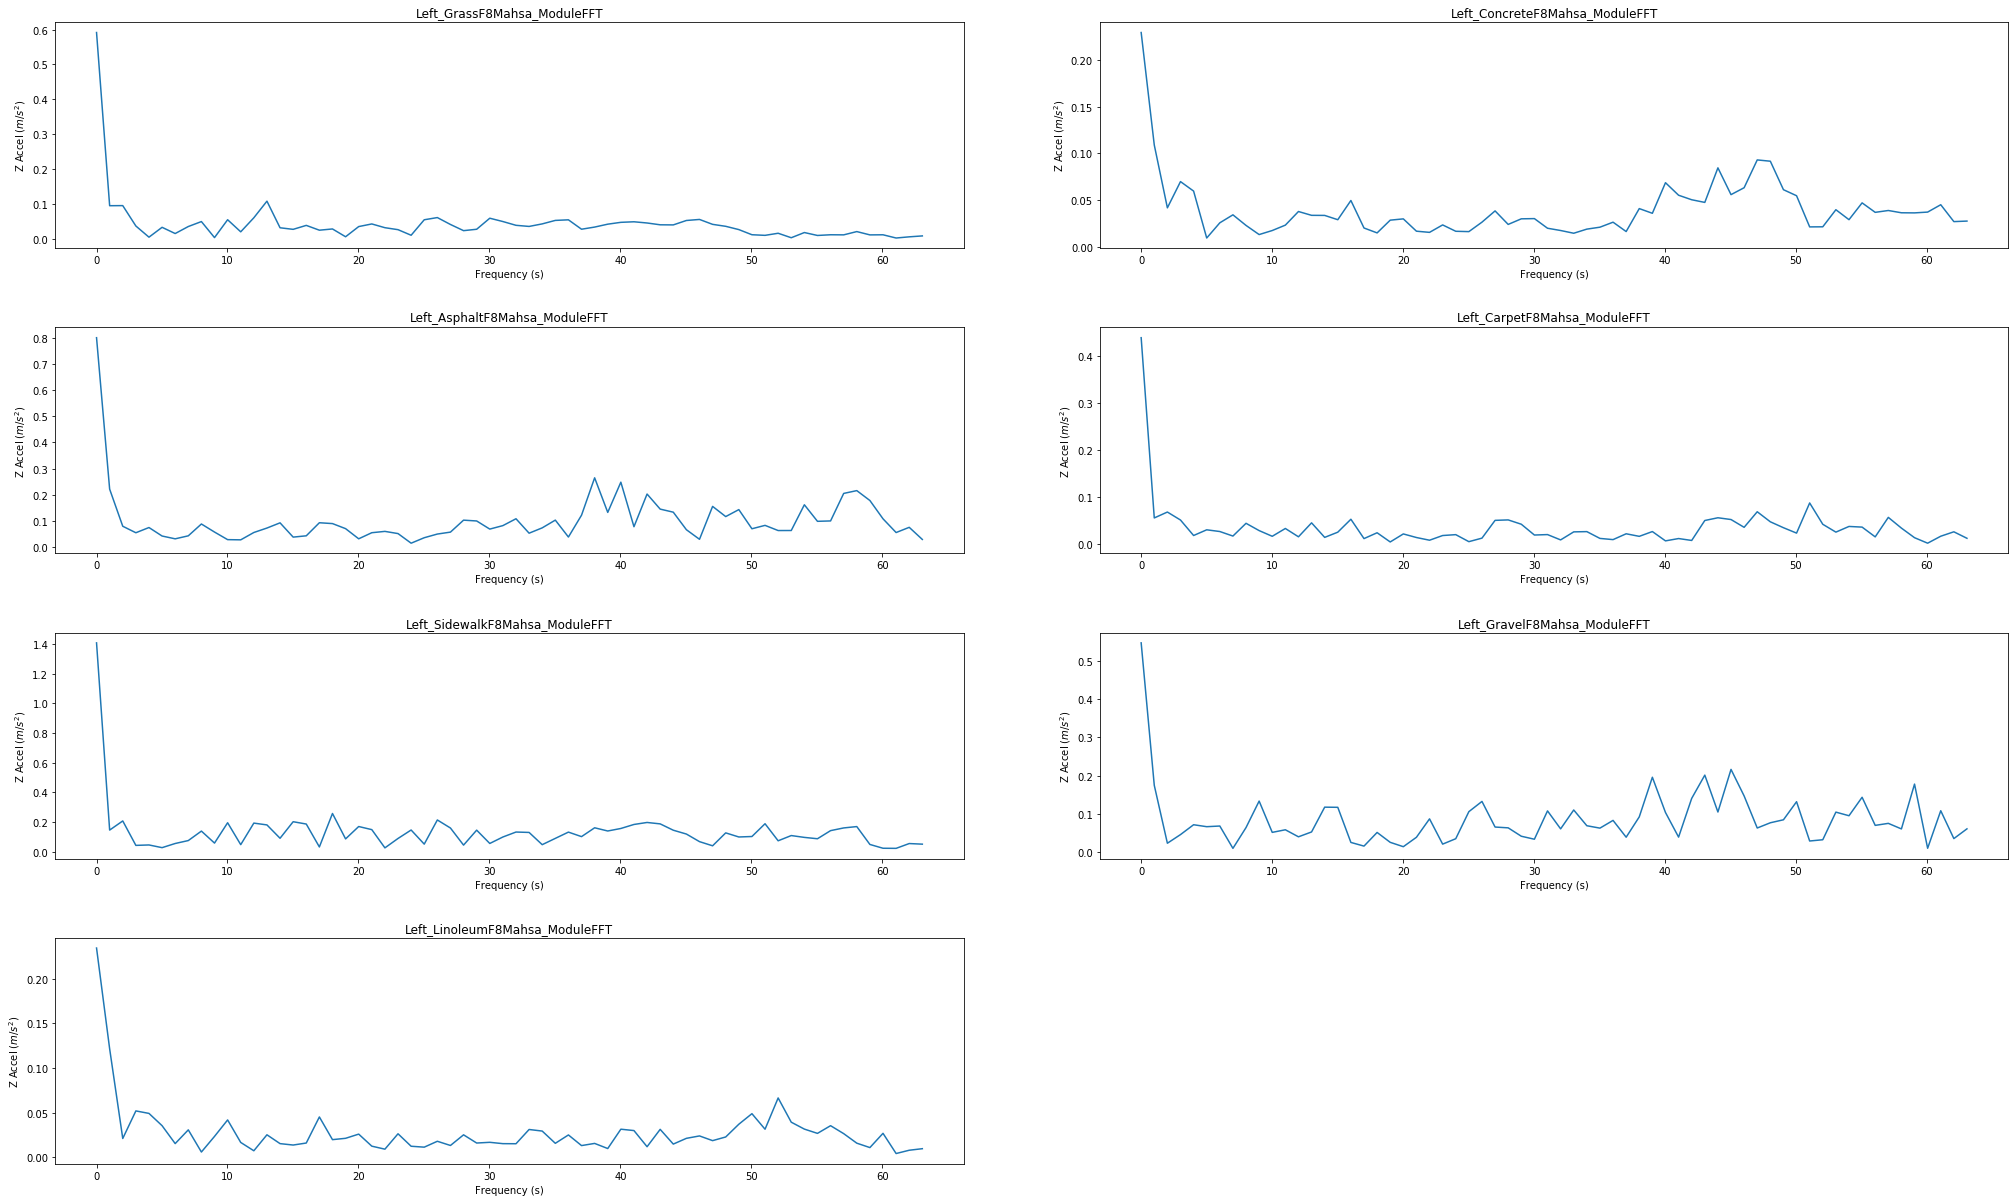

In [42]:
# Plot all the Frame FFTs for 0th window
plot_all(np_to_pd(ffts_to_plot, windowed=True), x_axis='Frequency', y_axis='Z Accel', windowed=True)

### Part (b) - PSD

In [43]:
datasets_psd = {}
datasets_psd_log = {}

# Find the PSD and log(PSD) of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_psd = []
    dataset_psd_log = []
    
    for window in dataset:
        # Frequencies depedent on dataset and device used
        f_samp, f_low, f_high = get_frequencies(label)
        
        # Only include frequency bins up to and a little bit past the cutoff frequency
        # Everything past that is useless because its the same on all terrains
        window_size = get_window_size(label)
        n_bins = int(window_size / f_samp * f_low) + N_BINS_OVER_CUTOFF
        window_psd = np.zeros((n_bins, N_DATA_COL))
        window_psd_log = np.zeros((n_bins, N_DATA_COL))
        
        # Calculate PSD for each axes
        for i in range(N_DATA_COL):
            # Normalized PSD - Returns frequencies and power density
            freq, Pxx = signal.periodogram(window[:, i], f_samp)
            window_psd[:, i] = np.resize(Pxx[1:], n_bins)
            
            # Calculate log10 of PSD, replacing points where PSD = 0 with 0 to avoid division by 0
            for j in range(len(window_psd[:, i])):
                if (window_psd[j, i] == 0):
                    window_psd_log[j, i] = 0
                else:
                    window_psd_log[j, i] = np.log10(window_psd[j, i])
            
        # Append freq column
        freq_col = np.transpose([np.resize(freq[:-1], n_bins)])
        window_psd = np.append(window_psd, freq_col, axis=1)
        window_psd_log = np.append(window_psd_log, freq_col, axis=1)
        
        dataset_psd.append(window_psd)
        dataset_psd_log.append(window_psd_log)
        
    datasets_psd.update({label + 'PSD': dataset_psd})
    datasets_psd_log.update({label +'PSDLog': dataset_psd_log})

In [44]:
# Check again if its constructed correctly
print('Num PSD\'d windowed datasets: {}'.format(len(datasets_psd)))
print('Num of PSD\'d windows in first dataset: {}'.format(len(datasets_psd[dataset_labels[0]+'PSD'])))
print('Shape of PSD\'d individual window: {}'.format(datasets_psd[dataset_labels[0]+'PSD'][0].shape))

Num PSD'd windowed datasets: 60
Num of PSD'd windows in first dataset: 183
Shape of PSD'd individual window: (64, 7)


<Figure size 432x288 with 0 Axes>

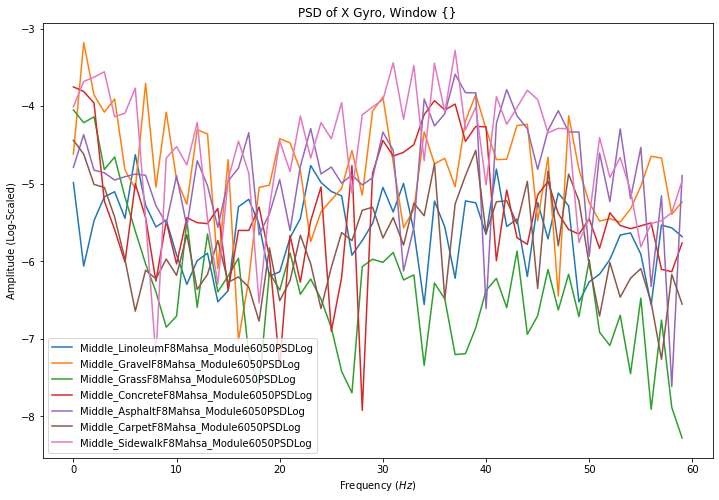

In [45]:
# Plot Z Accel of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Middle' in label and 'Power' not in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(psds_to_plot, win_num=0, dirn=3, transform_name='PSD')

<Figure size 432x288 with 0 Axes>

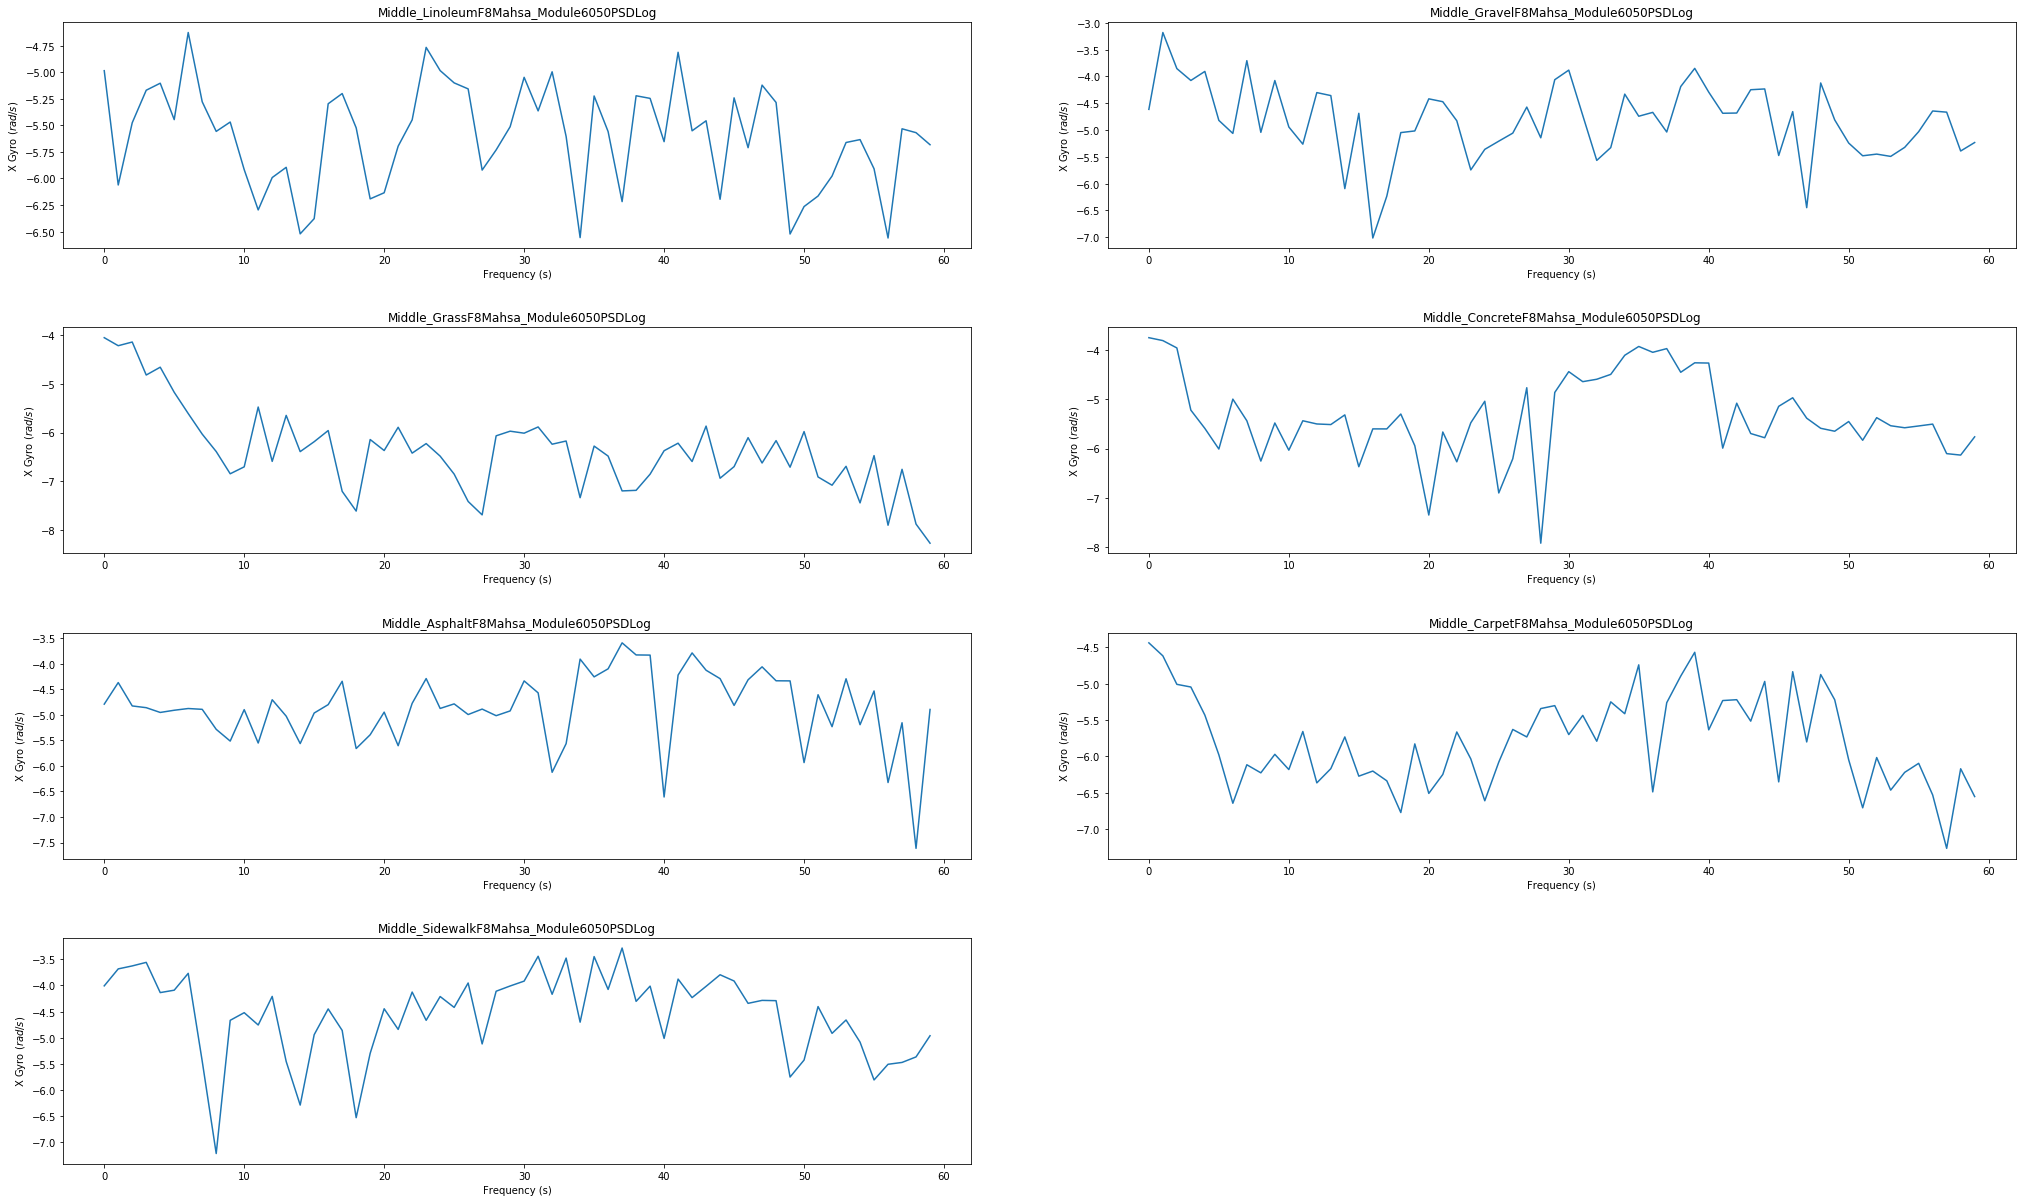

In [46]:
# Plot all PSDs of Z Accel for 0th window
plot_all(np_to_pd(psds_to_plot, windowed=True), x_axis='Frequency', y_axis='X Gyro', windowed=True)

#### Data Structure:

`Labelled Terrain Dataset
-> Time Window
---> 2D NumPy Array
-----> Row = Transform Value for Frequency
-----> Col = Dirn | Frequency`

### Part (c) - 3D Visualization

In [47]:
'''Plot the set transforms in 3d'''
def plot_transforms_3d(datasets_transformed, win_num, dirn, transform_name):
    plt.clf()
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca(projection='3d')
    
    # Specific to FFT or PSD
    if transform_name == 'FFT':
        z_lim = (0, 1.6)
        ax.set_zlim(z_lim[0], z_lim[1])
        ax.set_zlabel('Amplitude (Normalized to Window Size)')
        
    elif transform_name == 'PSD':
        z_lim = (-10, -30)
        ax.set_zlim(z_lim[0], z_lim[1])
        ax.set_zlabel('Amplitude (Log-Scaled)')
    
    n_datasets = len(datasets_transformed)
    
    # Change y axis to corespond with terrain labels
    ax.set_ylim(0.5, n_datasets+0.5)
    subset = np.arange(0, n_datasets, dtype=int)
    ax.set_yticks(np.add(subset, 1.5))
    y_labels = [get_terrain_name(get_terrain_num(key)) for key in datasets_transformed.keys()]
    ax.set_yticklabels(y_labels)
    
    
    ax.set_xlabel('Frequency ($Hz$)')
    ax.set_title(transform_name + ' of ' + data_columns[dirn] + ', Window {}')
    
    # Bar graph paremeters
    width = depth = 0.75
    
    # TODO: Sort by max amplitude
    # Plot each dataset FFT
    for i, (label, dataset) in enumerate(datasets_transformed.items()):
        # To plot
        x = dataset[win_num][:, -1]
        y = [i+1]
        top = dataset[win_num][:, dirn]
        
        # Specific to transform
        bot = np.full(top.shape, z_lim[0])
        ax.bar3d(x, y, bot, width, depth, top, alpha=0.8)
    
    plt.show()

<Figure size 432x288 with 0 Axes>

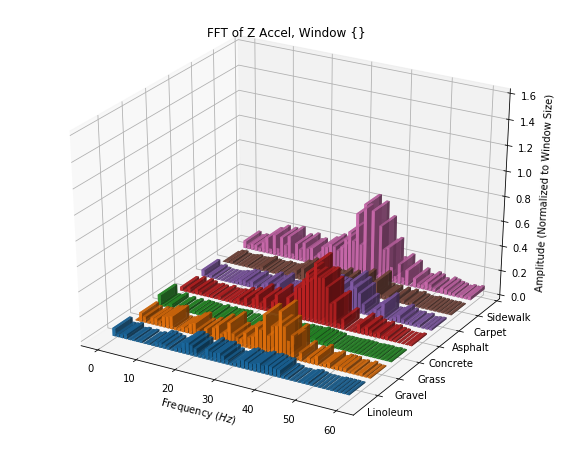

In [49]:
# Plot 3D Z Accel FFT of 0th window
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_transforms_3d(ffts_to_plot, win_num=0, dirn=2, transform_name='FFT')

<Figure size 432x288 with 0 Axes>

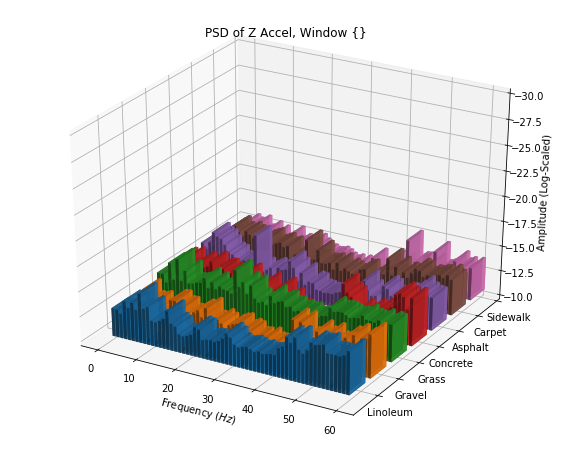

In [51]:
# Plot 3D Z Accel PSD of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label }
plot_transforms_3d(psds_to_plot, win_num=0, dirn=2, transform_name='PSD')

### Part (d) - Spectograms

In [52]:
'''Plot a spectogram of data'''
def plot_spectogram(set_label, dirn, size):
    # Get sampling frequency for label
    f_samp, f_low, f_high = get_frequencies(set_label)
    
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Compute spectogram directly using time series data
    plt.specgram(datasets[set_label][:, dirn], NFFT=size, Fs=f_samp)
    plt.title('Spectrogram of {} for {}'.format(data_columns[dirn], set_label))
    plt.xlabel('Data Window')
    plt.xticks(label=np.arange(0, len(datasets_windowed[set_label])))
    plt.ylabel('Frequency ($Hz$)')
    
    plt.show()

<Figure size 432x288 with 0 Axes>

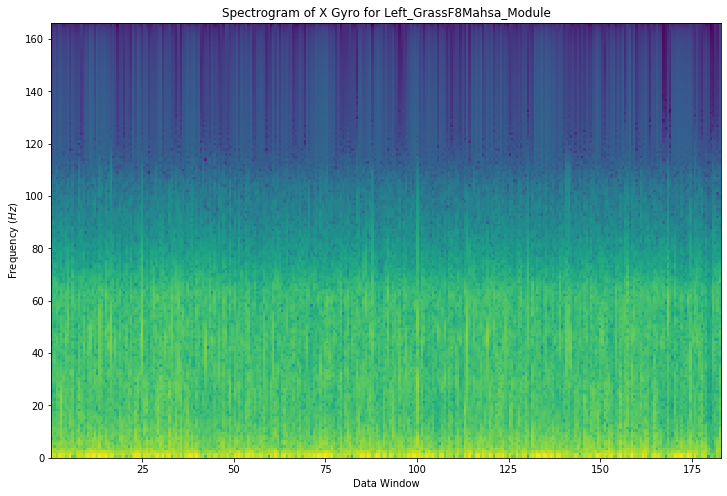

In [53]:
# X Accel
plot_spectogram(dataset_labels[0], dirn=3, size=get_window_size(dataset_labels[0]))

## Part 5 - Feature Extraction

#### Extract possibly relevant features (e.g. Mean, Min, Skew) from each data window

In [54]:
# Feature extraction functions

# For small float values
EPSILON = 0.00001

'''L2 norm of an array'''
def l2norm(array):
    return np.linalg.norm(array, ord=2)

'''Correlation of an array with itself'''
def autocorr(array):
    return np.correlate(array, array)[0]

'''Root mean squared of an array'''
def rms(array):
    return np.sqrt(np.mean(array ** 2))

'''Zero crossing rate of an array as a fraction of total size of array'''
def zcr(array):
    # Locations where array > 0, put -1 and 1 for rising/falling,
    # divide by total datapoints
    return len(np.nonzero(np.diff(array > 0))[0]) / len(array)

'''Mean square frequency'''
def msf(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), np.power(psd_amps, 2)))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Root mean square frequency'''
def rmsf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

'''Frequency center'''
def fc(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), psd_amps))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Variance frequency'''
def vf(freqs, psd_amps):
    return msf(freqs, psd_amps) - fc(freqs, psd_amps) ** 2

'''Root variance frequency'''
def rvf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

In [55]:
'''Extract given features from everything in dataset'''
def feature_all(features, datasets, regular=True):
    datasets_feat = {}
    
    # Calculate features for each window of each column of each dataset
    for label, dataset in datasets.items():
        directions = {}
        
        # Loop over data columns
        for i, direction in enumerate(get_columns(label)[:N_DATA_COL]):
            feats = {}
            
            if (regular):
                '''Execute a function over all windows'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, i]))
                    
                    return feat_in_window
                    
            else:
                '''Alternate defintion for frequency functions'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, -1], window[:, i]))
                    
                    return feat_in_window
                    
                    
            # Execute every function over all windows    
            for feat_name, feat_func in features.items():
                feats.update({feat_name: function_all_windows(feat_func)})
            
            directions.update({direction: pd.DataFrame.from_dict(feats)})

        datasets_feat.update({label.replace('PSD', ''): directions})
    
    return datasets_feat

In [56]:
'''Plot a feature on all terrains for each time window'''
def plot_set_features(datasets_feat, dirn, feat_name, placement_name, ylim=None, xlim=None):
    plt.clf()
    plt.figure(figsize=(10,8))
    
    for label, dataset in datasets_feat.items():
        plt.plot(dataset[dirn][feat_name], label=label)
        
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    
    plt.ylabel(feat_name)
    plt.xlabel('Window #')
    plt.title(placement_name + ' ' + dirn)
    plt.legend()
    plt.show()

### Part (a) - Time Domain Features

In [57]:
# Time domain feature functions and names
time_features = {'Mean': np.mean, 'Std Dev': np.std,  'L2 Norm': l2norm, 'Autocorrelation': autocorr, 
                 'Max': np.amax, 'Min' : np.amin, 'Root Mean Squared': rms, 'Zero Crossing Rate': zcr, 
                 'Skew': stats.skew, 'Excess Kurtosis': stats.kurtosis} 

# Create array of features of each window for each dataset and direction
datasets_feat_time = feature_all(time_features, datasets_windowed)

In [58]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_time)))
print('Num directions: {}'.format(len(datasets_feat_time[dataset_labels[0]])))
print('Shape of first dataset first direction: {}'.format(datasets_feat_time[dataset_labels[0]]['X Gyro'].shape))

Num datasets: 60
Num directions: 6
Shape of first dataset first direction: (183, 10)


<Figure size 432x288 with 0 Axes>

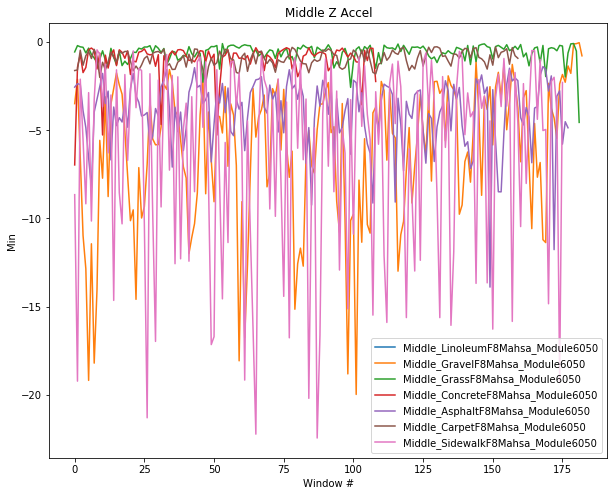

In [59]:
# Plot Min of frame Z Accel
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_time.items() if 'Middle' in label in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='Z Accel', feat_name='Min', placement_name='Middle')

### Part (b) - Frequency Domain Features

In [60]:
# Frequency domain feature functions and names
freq_features = {'Mean Square Frequency': msf, 'Root Mean Square Frequency': rmsf, 'Frequency Center': fc, 
                 'Variance Frequency': vf, 'Root Variance Frequency': rvf}

# Create array of features of each window for each dataset and direction
datasets_feat_freq = feature_all(freq_features, datasets_psd, regular=False)

In [61]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_freq)))
print('Num directions: {}'.format(len(datasets_feat_freq[dataset_labels[0]])))
print('Shape of one direction: {}'.format(datasets_feat_freq[dataset_labels[0]]['X Gyro'].shape))

Num datasets: 60
Num directions: 6
Shape of one direction: (183, 5)


<Figure size 432x288 with 0 Axes>

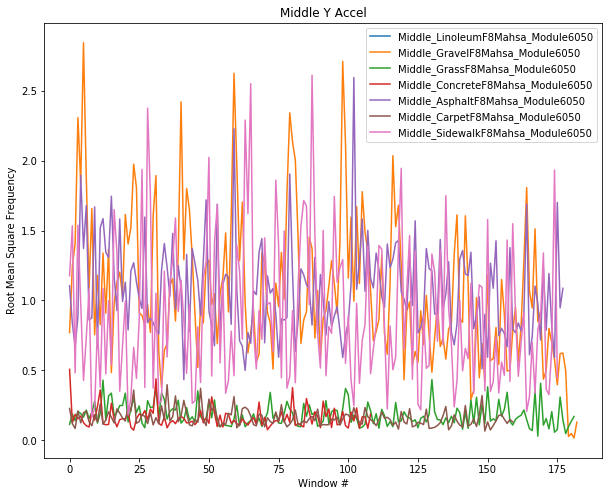

In [62]:
# Plot RMSF of Y Accel
feat_datasets_to_plot = {label: feature for label, feature in datasets_feat_freq.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='Y Accel', feat_name='Root Mean Square Frequency', placement_name='Middle')

#### Data Structure

`Terrain Dataset Dictionary
-> Direction Dictionary 
---> Pandas Array
-----> Row = Window #
-----> Col = Extracted Feature`

## Part 6 - Standardization, Columning, and Combining Datasets

**Since Z Gyro data is often cutoff out of range on old datasets, possible to get PSD of zero which results in NaN values**

This is likely the cause of some of the errors below

In [63]:
# Convert transformed data to Pandas
datasets_fft = np_to_pd(datasets_fft, windowed=True)
datasets_psd_log = np_to_pd(datasets_psd_log, windowed=True)

In [64]:
# Run to convert transformed data back to Numpy
#datasets_fft = pd_to_np(datasets_fft, windowed=True)
#datasets_psd_log = pd_to_np(datasets_psd_log, windowed=True)

In [65]:
# Add time and frequency features together
datasets_feat = {}

for label, dataset in datasets_feat_time.items():
    dataset_feat = {}
    
    for dirn_label, dirn_df in dataset.items():
        new_df = dirn_df.join(datasets_feat_freq[label][dirn_label], how='outer')
        dataset_feat.update({dirn_label: new_df})
    
    datasets_feat.update({label: dataset_feat})

In [66]:
# Confirm formatting
datasets_feat[dataset_labels[0]]['Y Accel'].head()

Mean   Std Dev     L2 Norm  Autocorrelation        Max       Min  \
0  5.698948  2.167619  111.264560     12379.802374   9.746741  3.181796   
1  9.329479  0.606489  170.606365     29106.531759  10.438099  7.881783   
2  5.040103  4.251496  120.325083     14478.125521   9.984876 -4.221937   
3 -6.451269  1.559573  121.115776     14669.031263  -4.203900 -9.640728   
4 -7.843577  1.237384  144.902004     20996.590773  -5.302533 -9.988890   

   Root Mean Squared  Zero Crossing Rate      Skew  Excess Kurtosis  \
0           6.097260            0.000000  0.494285        -1.460580   
1           9.349171            0.000000 -0.790146        -0.238310   
2           6.593774            0.009009 -0.630586        -0.806099   
3           6.637104            0.000000 -0.727429        -0.726166   
4           7.940581            0.000000  0.045678        -1.084806   

   Mean Square Frequency  Root Mean Square Frequency  Frequency Center  \
0               0.039701                    0.199252          1.163317   
1               0.031803                    0.178334          3.201557   
2               0.915583                    0.956861          1.925266   
3               0.384527                    0.620102          2.872052   
4               0.013337                    0.115485          1.371263   

   Variance Frequency  Root Variance Frequency  
0           -1.313606                 0.199252  
1          -10.218162                 0.178334  
2           -2.791065                 0.956861  
3           -7.864157                 0.620102  
4           -1.867025                 0.115485

### Part (a) - Standardization

#### Standardize each feature to mean 0 and standard deviation 1. This makes feature selection and classification easier.

In [67]:
'''Normalize already featured datasets'''
def normalize_datasets(datasets, windowed=False):
    # Normalization function
    from sklearn.preprocessing import scale
    
    datasets_norm = {}
    
    # Go through windowed data (transforms) or dictionary data (features)
    for label, dataset in datasets.items():
        if windowed:
            dataset_norm = []
            for window_df in dataset:
                window_df = window_df.dropna()
                dataset_norm.append(window_df.apply(scale))
        else:
            dataset_norm = {}
            for dirn_label, dirn_df in dataset.items():
                dirn_df = dirn_df.dropna()
                dataset_norm.update({dirn_label: dirn_df.apply(sklearn.preprocessing.scale)})
        
        datasets_norm.update({label: dataset_norm})
    
    return datasets_norm

In [68]:
# So we can remove infinites
pd.set_option('use_inf_as_na', True)

datasets_feat_norm = normalize_datasets(datasets_feat)
datasets_fft_norm = normalize_datasets(datasets_fft, windowed=True)
datasets_psd_norm = normalize_datasets(datasets_psd_log, windowed=True)

In [69]:
datasets_feat_norm[dataset_labels[0]]['Y Accel'].head()

Mean   Std Dev   L2 Norm  Autocorrelation       Max       Min  \
0  0.722236  0.237157 -0.208075        -0.406586  0.905985  0.801407   
1  1.280430 -0.881593  1.197908         1.377101  1.018718  1.485061   
2  0.620939  1.730523  0.006596        -0.182827  0.944816 -0.275530   
3 -1.145860 -0.198586  0.025330        -0.162470 -1.368803 -1.063741   
4 -1.359927 -0.429475  0.588896         0.512282 -1.547946 -1.114384   

   Root Mean Squared  Zero Crossing Rate      Skew  Excess Kurtosis  \
0          -0.208075           -0.507822  0.769652        -0.748990   
1           1.197908           -0.507822 -0.907009         0.015224   
2           0.006596            1.267938 -0.698724        -0.339781   
3           0.025330           -0.507822 -0.825141        -0.289804   
4           0.588896           -0.507822  0.184054        -0.514041   

   Mean Square Frequency  Root Mean Square Frequency  Frequency Center  \
0              -0.599349                   -0.637487         -0.478815   
1              -0.627757                   -0.716258          0.000906   
2               2.550950                    2.215460         -0.299482   
3               0.640890                    0.947319         -0.076646   
4              -0.694175                   -0.952929         -0.429873   

   Variance Frequency  Root Variance Frequency  
0            0.238612                -0.637487  
1            0.159206                -0.716258  
2            0.225437                 2.215460  
3            0.180197                 0.947319  
4            0.233677                -0.952929

<Figure size 432x288 with 0 Axes>

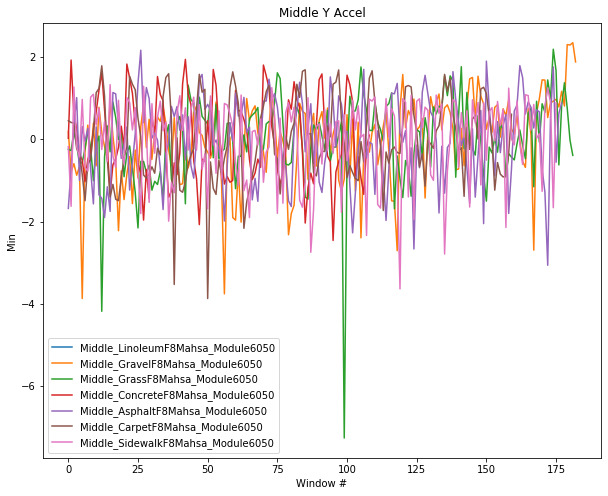

In [70]:
# Plot normalized features
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_norm.items() if 'Middle' in label in label and 'Power' not in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='Y Accel', feat_name='Min', placement_name='Middle')

/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


<Figure size 432x288 with 0 Axes>

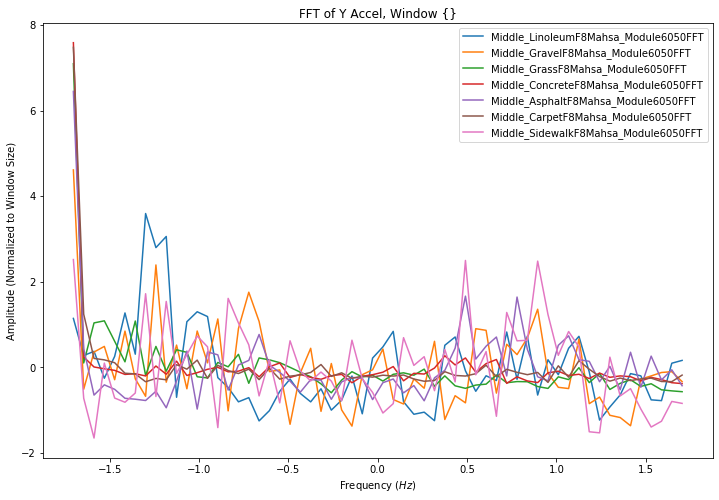

In [71]:
# Plot normalized fft
ffts_to_plot = {label: dataset for label, dataset in datasets_fft_norm.items() if 'Middle' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(pd_to_np(ffts_to_plot, windowed=True), dirn=1, win_num=0, transform_name='FFT')

### Part (b) - Columning Data

#### Combine IMU data from each direction into single dataframes with columns for each feature in each direction

#### Part (i) - Extracted Featured Data

In [72]:
'''Append a tag to the end of every column name of a dataframe'''
def append_all_columns(columns, append_tag):
    new_columns = []
    
    for column in columns:
        new_columns.append(column + ' ' + append_tag)
    
    return new_columns

In [73]:
'''Combined directions of a featured dataset'''
def combine_columns(datasets):
    datasets_combined = {}
    
    for label, dataset in datasets.items():
        # Get labels array of first column
        df_combined = pd.DataFrame()
        
        # Append direction name to feature name and combine everything in one frame
        for dirn_label, dirn_df in dataset.items():
            df_copy = pd.DataFrame(dirn_df)
            
            # Add direction and placement tags
            df_copy.columns = append_all_columns(dirn_df.columns, dirn_label)
            df_copy.columns = append_all_columns(dirn_df.columns, get_placement(label))
            
            df_combined = df_combined.join(dirn_df, how='outer')
        
        datasets_combined.update({label: df_combined})
    
    return datasets_combined

In [74]:
# Take frame data and combine directions
datasets_feat_columned = combine_columns(datasets_feat_norm)

# Confirm formatting
datasets_feat_columned[dataset_labels[0]].head()

Mean X Accel Left  Std Dev X Accel Left  L2 Norm X Accel Left  \
0          -1.122447              0.140664              0.705539   
1           0.285335              0.745896             -1.463949   
2           1.059815              0.714276              0.157407   
3           1.082937              0.094170              0.100928   
4          -0.695240              1.272370             -0.130234   

   Autocorrelation X Accel Left  Max X Accel Left  Min X Accel Left  \
0                      0.665913         -0.964424         -0.921800   
1                     -1.361744          0.468269         -0.061131   
2                     -0.022086          1.163103          0.794045   
3                     -0.086224          0.883158          0.792429   
4                     -0.335596         -0.063559         -0.863248   

   Root Mean Squared X Accel Left  Zero Crossing Rate X Accel Left  \
0                        0.705539                        -0.426671   
1                       -1.463949                         0.064403   
2                        0.157407                        -0.426671   
3                        0.100928                        -0.426671   
4                       -0.130234                         0.064403   

   Skew X Accel Left  Excess Kurtosis X Accel Left  ...  Min Z Gyro Left  \
0           1.143777                     -0.296865  ...        -0.395068   
1          -0.484818                     -0.315829  ...        -0.962735   
2          -0.674040                     -0.645567  ...         0.347054   
3          -1.688850                      0.535922  ...         0.097573   
4           1.298272                     -0.006713  ...        -0.087776   

   Root Mean Squared Z Gyro Left  Zero Crossing Rate Z Gyro Left  \
0                      -0.142298                        0.055284   
1                      -0.094383                        0.975010   
2                       1.058563                       -0.864442   
3                       0.300483                       -0.864442   
4                       0.573794                       -0.864442   

   Skew Z Gyro Left  Excess Kurtosis Z Gyro Left  \
0         -0.356219                    -0.873486   
1         -0.409017                    -0.877148   
2         -1.551036                     1.182303   
3         -0.106414                    -0.799326   
4          0.033325                    -0.948571   

   Mean Square Frequency Z Gyro Left  Root Mean Square Frequency Z Gyro Left  \
0                          -0.134702                               -0.441905   
1                          -0.124880                               -0.303286   
2                           0.022682                                0.590934   
3                          -0.143169                               -0.666029   
4                          -0.137493                               -0.494133   

   Frequency Center Z Gyro Left  Variance Frequency Z Gyro Left  \
0                     -0.485092                        0.480871   
1                     -0.902776                        0.599846   
2                      0.771831                       -0.379754   
3                     -1.205619                        0.632413   
4                     -0.951017                        0.607660   

   Root Variance Frequency Z Gyro Left  
0                            -0.441905  
1                            -0.303286  
2                             0.590934  
3                            -0.666029  
4                            -0.494133  

[5 rows x 90 columns]

#### Part (ii) - Transformed Data

In [75]:
'''Combined direction columns for transformed data'''
def combine_transform_columns(datasets):
    combined_datasets = {}
    
    for label, dataset in datasets.items():
        combined_windows = []
        
        for window in dataset:
            window_as_row = pd.DataFrame()
            
            # Turn each window 2D dataframe into a single row dataframe
            for row in window.iterrows():
                for data_column in data_columns:
                    combined_column_name = get_transform(label) + ' {} Hz '.format(round(row[1]['Frequency']))
                    combined_column_name +=  data_column + ' ' + get_placement(label)
                    window_as_row.insert(0, combined_column_name, [row[1][data_column]])
            
            combined_windows.append(window_as_row)
        
        # Combine all the single row dataframes into one dataframe
        combined_datasets.update({label: pd.concat(combined_windows, ignore_index=True)})
    
    return combined_datasets

In [76]:
datasets_fft_columned = combine_transform_columns(datasets_fft)

In [77]:
datasets_psd_log_columned = combine_transform_columns(datasets_psd_log)

In [78]:
# Check FFT data
datasets_fft_columned[dataset_labels[0] + 'FFT']

FFT 63.0 Hz Z Gyro Left  FFT 63.0 Hz Y Gyro Left  \
0                   0.003105                 0.001434   
1                   0.002283                 0.001098   
2                   0.003576                 0.000494   
3                   0.000178                 0.001079   
4                   0.002359                 0.000731   
5                   0.002708                 0.000205   
6                   0.000446                 0.000762   
7                   0.001941                 0.001981   
8                   0.003479                 0.000398   
9                   0.002620                 0.000967   
10                  0.002575                 0.001314   
11                  0.001663                 0.000672   
12                  0.001187                 0.000558   
13                  0.001185                 0.001141   
14                  0.001180                 0.001214   
15                  0.000413                 0.001101   
16                  0.001471                 0.001280   
17                  0.000947                 0.001743   
18                  0.005486                 0.000399   
19                  0.002774                 0.000373   
20                  0.001547                 0.000561   
21                  0.001547                 0.000487   
22                  0.001536                 0.001061   
23                  0.002160                 0.001820   
24                  0.001061                 0.001172   
25                  0.002400                 0.001261   
26                  0.004155                 0.000683   
27                  0.000572                 0.000414   
28                  0.004166                 0.001050   
29                  0.006285                 0.001965   
..                       ...                      ...   
153                 0.000212                 0.000420   
154                 0.000396                 0.000416   
155                 0.000584                 0.000874   
156                 0.005256                 0.000168   
157                 0.008227                 0.001287   
158                 0.005388                 0.001472   
159                 0.001406                 0.000486   
160                 0.000150                 0.000441   
161                 0.000166                 0.001070   
162                 0.001430                 0.000191   
163                 0.002867                 0.000532   
164                 0.002059                 0.000127   
165                 0.002490                 0.001248   
166                 0.001867                 0.001230   
167                 0.001289                 0.001480   
168                 0.000658                 0.000972   
169                 0.001333                 0.000257   
170                 0.001296                 0.000845   
171                 0.001088                 0.000311   
172                 0.000945                 0.000426   
173                 0.001269                 0.000195   
174                 0.001776                 0.000450   
175                 0.001295                 0.000605   
176                 0.002178                 0.001086   
177                 0.001749                 0.000211   
178                 0.003318                 0.000136   
179                 0.005169                 0.000329   
180                 0.000053                 0.000138   
181                 0.000595                 0.000983   
182                 0.001552                 0.000559   

     FFT 63.0 Hz X Gyro Left  FFT 63.0 Hz Z Accel Left  \
0                   0.000579                  0.008608   
1                   0.000344                  0.009173   
2                   0.001142                  0.009775   
3                   0.000755                  0.003712   
4                   0.000073                  0.007195   
5                   0.000173                  0.005431   
6                   0.000933                  0.008997   
7     

In [79]:
# Check PSD data
datasets_psd_log_columned[dataset_labels[0] + 'PSDLog']

PSD 63.0 Hz Z Gyro Left  PSD 63.0 Hz Y Gyro Left  \
0                  -4.699126                -5.551056   
1                  -4.985639                -5.790810   
2                  -4.572908                -6.265054   
3                  -7.102687                -6.176096   
4                  -4.854624                -5.683953   
5                  -4.865828                -5.996329   
6                  -6.203434                -5.652351   
7                  -5.012827                -5.533035   
8                  -4.607607                -6.705698   
9                  -4.873973                -5.576622   
10                 -4.882619                -5.466338   
11                 -5.168436                -6.913769   
12                 -5.524662                -6.238287   
13                 -5.609968                -5.579317   
14                 -5.540122                -5.606160   
15                 -5.993281                -5.187299   
16                 -5.290333                -5.165764   
17                 -5.674320                -5.154055   
18                 -4.219817                -7.456068   
19                 -4.799913                -6.794458   
20                 -5.377887                -6.537708   
21                 -5.378168                -6.114599   
22                 -5.395006                -5.899359   
23                 -5.002484                -5.295290   
24                 -5.621010                -5.703913   
25                 -4.874410                -7.065173   
26                 -4.474956                -6.146666   
27                 -6.564243                -7.982758   
28                 -4.502097                -5.350048   
29                 -4.133354                -5.148183   
..                       ...                      ...   
153                -7.020959                -6.429556   
154                -6.422252                -7.123876   
155                -6.313232                -5.901415   
156                -4.238132                -5.814349   
157                -3.842667                -5.091297   
158                -4.228082                -5.611217   
159                -5.611267                -5.815327   
160                -8.065175                -7.133059   
161                -6.981235                -6.786125   
162                -5.343602                -6.346913   
163                -4.758851                -7.082880   
164                -5.091928                -6.793736   
165                -4.885100                -6.020804   
166                -5.182556                -5.552173   
167                -5.476733                -5.370184   
168                -5.943062                -6.326164   
169                -5.527609                -6.368051   
170                -5.471329                -6.037486   
171                -5.619204                -7.040545   
172                -5.692803                -6.023221   
173                -5.514603                -6.679457   
174                -5.245644                -6.677377   
175                -5.448443                -6.027586   
176                -4.968853                -5.402754   
177                -5.283672                -6.297797   
178                -4.655569                -7.747708   
179                -4.278711                -6.938377   
180                -8.334126                -7.638651   
181                -6.278949                -6.561074   
182                -5.291943                -7.744469   

     PSD 63.0 Hz X Gyro Left  PSD 63.0 Hz Z Accel Left  \
0                  -6.087925                 -4.261001   
1                  -6.430636                 -3.960260   
2                  -5.406441                 -3.484309   
3                  -5.804098                 -4.042321   
4                  -6.584480                 -3.363361   
5                  -7.556788                 -3.706010   
6                  -6.092615                 -4.028765   
7     

### Part (c) - Adding Labels

Create a new column containg the an integer label for each terrain.

In [80]:
'Add labels to a dataset'
def insert_labels(datasets):
    # Returns new datasets
    datasets_copy = {}
    
    # Add to each dataframe of a dataset
    for label, dataset in datasets.items():
        terrain_num = get_terrain_num(label)
        labels = [terrain_num for _ in range(len(dataset))]
        
        dataset_copy = dataset.copy()
        dataset_copy.insert(0, 'Label', labels)
        
        datasets_copy.update({label: dataset_copy})
    
    return datasets_copy

In [89]:
# Add labels
datasets_feat_columned = insert_labels(datasets_feat_columned)
datasets_fft_columned = insert_labels(datasets_fft_columned)
datasets_psd_log_columned = insert_labels(datasets_psd_log_columned)

In [90]:
# Check labelled feature data
datasets_feat_columned[dataset_labels[0]]

Label  Mean X Accel Left  Std Dev X Accel Left  L2 Norm X Accel Left  \
0        5          -1.122447              0.140664              0.705539   
1        5           0.285335              0.745896             -1.463949   
2        5           1.059815              0.714276              0.157407   
3        5           1.082937              0.094170              0.100928   
4        5          -0.695240              1.272370             -0.130234   
5        5          -1.249523             -0.254599              1.004533   
6        5          -0.409946             -0.280170             -1.235225   
7        5           1.103989              0.701377              0.266869   
8        5           1.173308              0.704032              0.444963   
9        5          -0.681182              0.098249             -0.463975   
10       5          -1.391879             -0.681506              1.363714   
11       5          -1.437967             -1.129684              1.475427   
12       5          -1.444812             -1.196449              1.493327   
13       5          -1.354077             -0.932831              1.249408   
14       5          -1.085576             -1.124788              0.505377   
15       5          -0.991682             -0.603897              0.273223   
16       5          -0.801590             -0.920026             -0.267540   
17       5          -0.441400             -0.657318             -1.221314   
18       5           0.110017              1.356897             -1.241028   
19       5           1.472894             -1.051946              1.063059   
20       5           0.532491              2.901035             -0.095352   
21       5          -1.246295             -0.433371              0.980897   
22       5           0.260991              0.878835             -1.421798   
23       5           1.455711             -0.791394              1.025048   
24       5           0.792613              1.446216             -0.268689   
25       5          -0.631044              0.567982             -0.482533   
26       5          -1.345754             -0.835425              1.230088   
27       5          -0.404621              1.791019             -0.527675   
28       5           0.329559              0.518560             -1.516764   
29       5           1.329356             -0.512030              0.695933   
..     ...                ...                   ...                   ...   
153      5          -0.440797              1.044922             -0.761717   
154      5           0.420079             -0.333902             -1.677450   
155      5           1.078334              0.689455              0.199033   
156      5           1.350919             -0.823701              0.735898   
157      5          -0.770800              2.152153              0.326729   
158      5          -1.129334              0.162982              0.726927   
159      5          -1.210046             -0.959389              0.852482   
160      5          -0.046243              1.946060             -0.876711   
161      5           1.236353             -0.958838              0.415442   
162      5           1.284326              0.003844              0.625210   
163      5          -0.195362             -0.118927             -1.694115   
164      5          -1.056243              0.474674              0.580376   
165      5          -1.064417             -0.530197              0.477321   
166      5          -0.414292             -0.209846             -1.208544   
167      5          -0.267380             -0.976315             -1.728656   
168      5           0.162332             -0.084967             -2.012554   
169      5           0.784193             -1.067534             -0.831066   
170      5           0.998049             -0.343089             -0.186265   
171      5           1.426706             -1.243133              0.932575   
172      5           1.470832             -1.255730              1.053998   
1

In [91]:
# Check labelled FFT data
datasets_fft_columned[dataset_labels[0] + 'FFT']

Label  FFT 63.0 Hz Z Gyro Left  FFT 63.0 Hz Y Gyro Left  \
0        5                 0.003105                 0.001434   
1        5                 0.002283                 0.001098   
2        5                 0.003576                 0.000494   
3        5                 0.000178                 0.001079   
4        5                 0.002359                 0.000731   
5        5                 0.002708                 0.000205   
6        5                 0.000446                 0.000762   
7        5                 0.001941                 0.001981   
8        5                 0.003479                 0.000398   
9        5                 0.002620                 0.000967   
10       5                 0.002575                 0.001314   
11       5                 0.001663                 0.000672   
12       5                 0.001187                 0.000558   
13       5                 0.001185                 0.001141   
14       5                 0.001180                 0.001214   
15       5                 0.000413                 0.001101   
16       5                 0.001471                 0.001280   
17       5                 0.000947                 0.001743   
18       5                 0.005486                 0.000399   
19       5                 0.002774                 0.000373   
20       5                 0.001547                 0.000561   
21       5                 0.001547                 0.000487   
22       5                 0.001536                 0.001061   
23       5                 0.002160                 0.001820   
24       5                 0.001061                 0.001172   
25       5                 0.002400                 0.001261   
26       5                 0.004155                 0.000683   
27       5                 0.000572                 0.000414   
28       5                 0.004166                 0.001050   
29       5                 0.006285                 0.001965   
..     ...                      ...                      ...   
153      5                 0.000212                 0.000420   
154      5                 0.000396                 0.000416   
155      5                 0.000584                 0.000874   
156      5                 0.005256                 0.000168   
157      5                 0.008227                 0.001287   
158      5                 0.005388                 0.001472   
159      5                 0.001406                 0.000486   
160      5                 0.000150                 0.000441   
161      5                 0.000166                 0.001070   
162      5                 0.001430                 0.000191   
163      5                 0.002867                 0.000532   
164      5                 0.002059                 0.000127   
165      5                 0.002490                 0.001248   
166      5                 0.001867                 0.001230   
167      5                 0.001289                 0.001480   
168      5                 0.000658                 0.000972   
169      5                 0.001333                 0.000257   
170      5                 0.001296                 0.000845   
171      5                 0.001088                 0.000311   
172      5                 0.000945                 0.000426   
173      5                 0.001269                 0.000195   
174      5                 0.001776                 0.000450   
175      5                 0.001295                 0.000605   
176      5                 0.002178                 0.001086   
177      5                 0.001749                 0.000211   
178      5                 0.003318                 0.000136   
179      5                 0.005169                 0.000329   
180      5                 0.000053                 0.000138   
181      5                 0.000595                 0.000983   
182      5                 0.001552                 0.000559   

     FFT 63.0 Hz X Gyro Left  FFT 63

### Part (d) - Combining Datasets

Combine data from every dataset into rows in a single dataframe

In [92]:
'''Combine data from labelled datasets into a single dataframe'''
def combine_datasets(datasets):
    return pd.concat(list(datasets.values()), ignore_index=True)

In [93]:
# Combine all data individually
# TODO: Combine each mounting source of a single dataset into a single dataframe so we can select across all
def separate_and_combine(datasets_columned, csv_tag):
    datasets_separated = {}
    
    # Separate according to mounting location
    for placement in placements:
        datasets = {label: dataset for label, dataset in datasets_columned.items() if placement in label}
        
        # Update if not empty
        if bool(datasets): 
            datasets_separated.update({placement: datasets})
    
    # Combine each mounting into a single combined dataframe and drop NaN values, export to csv
    for placement, datasets in datasets_separated.items():
        # NaN values usually come from cutoff range of Z gyro, so drop the column
        datasets_separated.update({placement: combine_datasets(datasets).dropna(axis='columns')})
        
        # Export to a csv file
        csv_filename = 'processed_data/' + placement + '_' + csv_tag + '.csv'
        datasets_separated[placement].to_csv(csv_filename, index=False)
                        
    # Return dictionary of each mounting location
    return datasets_separated

In [94]:
# Convert features
feat_combined = separate_and_combine(datasets_feat_columned, csv_tag='Features_Filt_Mahsa')

feat_combined['Middle'].tail()

Label  Mean X Accel Middle  Std Dev X Accel Middle  \
1801      6            -0.846848               -1.155410   
1802      6            -0.021590               -1.231574   
1803      6             0.211125               -2.132865   
1804      6             0.315237               -1.605279   
1805      6             0.489914               -2.138868   

      L2 Norm X Accel Middle  Autocorrelation X Accel Middle  \
1801               -1.193282                       -0.984408   
1802               -1.345895                       -1.056300   
1803               -2.201046                       -1.319494   
1804               -1.677792                       -1.186590   
1805               -2.090389                       -1.298786   

      Max X Accel Middle  Min X Accel Middle  \
1801           -1.190593            0.845964   
1802           -1.020336            1.245787   
1803           -1.354912            1.690773   
1804           -1.113657            1.517311   
1805           -1.400876            1.797356   

      Root Mean Squared X Accel Middle  Zero Crossing Rate X Accel Middle  \
1801                         -1.193282                          -0.570367   
1802                         -1.345895                          -1.410363   
1803                         -2.201046                          -1.877027   
1804                         -1.677792                          -0.570367   
1805                         -2.090389                          -2.157025   

      Skew X Accel Middle  ...  Min Z Gyro Middle  \
1801            -0.888599  ...           0.114058   
1802             0.555471  ...           0.506300   
1803             0.938994  ...           0.878401   
1804             0.190928  ...           0.751412   
1805             0.978920  ...           1.023789   

      Root Mean Squared Z Gyro Middle  Zero Crossing Rate Z Gyro Middle  \
1801                        -1.084251                          1.092294   
1802                        -1.337267                          0.815931   
1803                        -1.662305                          1.645022   
1804                        -1.604374                          2.750476   
1805                        -1.774620                          1.092294   

      Skew Z Gyro Middle  Excess Kurtosis Z Gyro Middle  \
1801           -0.832074                      -0.062854   
1802           -0.048076                       0.020898   
1803            1.371618                       3.755749   
1804           -0.025628                       0.712065   
1805            0.007770                      -0.748390   

      Mean Square Frequency Z Gyro Middle  \
1801                             0.203685   
1802                             0.556325   
1803                            -0.837086   
1804                            -0.466675   
1805                            -0.983076   

      Root Mean Square Frequency Z Gyro Middle  \
1801                                  0.440092   
1802                                  0.771402   
1803                                 -1.028651   
1804                                 -0.356587   
1805                                 -1.469428   

      Frequency Center Z Gyro Middle  Variance Frequency Z Gyro Middle  \
1801                       -0.025424                          0.216404   
1802                        0.168145                          0.102390   
1803                        2.378528                         -2.276596   
1804                        4.341315                         -6.044193   
1805                        1.968081                         -1.685697   

      Root Variance Frequency Z Gyro Middle  
1801                               0.440092  
1802                               0.771402  
1803                              -1.028651  
1804                              -0.356587  
1805                              -1.469428  

[5 rows x 91 columns]

In [95]:
# Convert features
fft_combined = separate_and_combine(datasets_fft_columned, csv_tag='FFTs_Filt_Mahsa')

fft_combined['Left'].tail()

Label  FFT 63.0 Hz Z Gyro Left  FFT 63.0 Hz Y Gyro Left  \
2138      5                 0.003531                 0.001274   
2139      5                 0.005957                 0.000196   
2140      5                 0.000129                 0.000159   
2141      5                 0.000082                 0.000189   
2142      5                 0.000868                 0.000468   

      FFT 63.0 Hz X Gyro Left  FFT 63.0 Hz Z Accel Left  \
2138                 0.000501                  0.004346   
2139                 0.001100                  0.027021   
2140                 0.000373                  0.009616   
2141                 0.000472                  0.011271   
2142                 0.001318                  0.027259   

      FFT 63.0 Hz Y Accel Left  FFT 63.0 Hz X Accel Left  \
2138                  0.021667                  0.041766   
2139                  0.009426                  0.005795   
2140                  0.003617                  0.005279   
2141                  0.008028                  0.005777   
2142                  0.013571                  0.002813   

      FFT 62.0 Hz Z Gyro Left  FFT 62.0 Hz Y Gyro Left  \
2138                 0.003634                 0.001130   
2139                 0.006045                 0.000320   
2140                 0.000250                 0.000103   
2141                 0.000043                 0.000080   
2142                 0.000778                 0.000248   

      FFT 62.0 Hz X Gyro Left  ...  FFT 1.0 Hz X Gyro Left  \
2138                 0.000682  ...                0.059873   
2139                 0.001269  ...                0.073795   
2140                 0.000317  ...                0.000471   
2141                 0.000231  ...                0.001144   
2142                 0.001308  ...                0.015058   

      FFT 1.0 Hz Z Accel Left  FFT 1.0 Hz Y Accel Left  \
2138                 0.279251                 2.285214   
2139                 0.183001                 0.720440   
2140                 0.005371                 0.040345   
2141                 0.005502                 0.009043   
2142                 0.018646                 0.031752   

      FFT 1.0 Hz X Accel Left  FFT 0.0 Hz Z Gyro Left  FFT 0.0 Hz Y Gyro Left  \
2138                 3.729752                2.223898                0.156142   
2139                 0.892341                0.783284                0.007630   
2140                 0.056636                0.028173                0.001922   
2141                 0.010811                0.006474                0.003331   
2142                 0.133631                0.064606                0.003625   

      FFT 0.0 Hz X Gyro Left  FFT 0.0 Hz Z Accel Left  \
2138                0.011282                 1.105864   
2139                0.109149                 0.102477   
2140                0.008817                 0.054933   
2141                0.004844                 0.042994   
2142                0.007063                 0.024176   

      FFT 0.0 Hz Y Accel Left  FFT 0.0 Hz X Accel Left  
2138                 6.113309                 3.602281  
2139                 7.382257                 6.895368  
2140                 7.925974                 6.284728  
2141                 7.862501                 6.377180  
2142                 7.998711                 6.325618  

[5 rows x 385 columns]

In [96]:
# Convert features
psd_log_combined = separate_and_combine(datasets_psd_log_columned, csv_tag='PSDLogs_Filt_Mahsa')

psd_log_combined['Right'].tail()

Label  PSD 63.0 Hz Z Gyro Right  PSD 63.0 Hz Y Gyro Right  \
2233      3                 -4.649514                 -5.225228   
2234      3                 -4.289449                 -6.257480   
2235      3                 -6.484296                 -7.635706   
2236      3                 -6.596025                 -8.343862   
2237      3                 -6.073488                 -8.277525   

      PSD 63.0 Hz X Gyro Right  PSD 63.0 Hz Z Accel Right  \
2233                 -5.016120                  -2.242081   
2234                 -5.863465                  -2.761957   
2235                 -8.717131                  -5.802225   
2236                 -7.964685                  -4.847587   
2237                 -9.128173                  -5.519109   

      PSD 63.0 Hz Y Accel Right  PSD 63.0 Hz X Accel Right  \
2233                  -3.050168                  -2.667448   
2234                  -3.428267                  -4.364909   
2235                  -7.153265                  -6.483844   
2236                  -6.154243                  -6.341028   
2237                  -4.682291                  -4.282668   

      PSD 62.0 Hz Z Gyro Right  PSD 62.0 Hz Y Gyro Right  \
2233                 -4.602456                 -5.396536   
2234                 -4.275075                 -6.470170   
2235                 -6.450198                 -7.533852   
2236                 -6.681410                 -8.245740   
2237                 -6.116030                 -8.700099   

      PSD 62.0 Hz X Gyro Right  ...  PSD 1.0 Hz X Gyro Right  \
2233                 -5.291962  ...                -2.751370   
2234                 -6.001363  ...                -4.192275   
2235                 -8.619376  ...                -6.147222   
2236                 -8.332690  ...                -6.042250   
2237                 -8.919322  ...                -5.211656   

      PSD 1.0 Hz Z Accel Right  PSD 1.0 Hz Y Accel Right  \
2233                 -2.359616                  0.193292   
2234                 -2.612052                 -0.303078   
2235                 -4.873209                 -3.840087   
2236                 -4.671357                 -3.523852   
2237                 -4.897258                 -1.962851   

      PSD 1.0 Hz X Accel Right  PSD 0.0 Hz Z Gyro Right  \
2233                  0.605864                -1.154796   
2234                 -0.309859                -0.524390   
2235                 -3.103450                -2.936428   
2236                 -2.921694                -3.239311   
2237                 -1.381150                -3.965540   

      PSD 0.0 Hz Y Gyro Right  PSD 0.0 Hz X Gyro Right  \
2233                -1.970871                -2.050275   
2234                -2.781494                -3.731938   
2235                -4.347423                -5.922560   
2236                -5.016102                -6.968313   
2237                -4.230734                -4.702644   

      PSD 0.0 Hz Z Accel Right  PSD 0.0 Hz Y Accel Right  \
2233                 -1.542992                  1.082577   
2234                 -2.036139                  0.109804   
2235                 -5.222322                 -3.365609   
2236                 -4.876405                 -3.535758   
2237                 -3.196517                 -1.211516   

      PSD 0.0 Hz X Accel Right  
2233                  1.320556  
2234                  0.259958  
2235                 -2.530185  
2236                 -2.827385  
2237                 -0.679036  

[5 rows x 385 columns]

## Part 7 - Feature Selection mRMR (minimum Redunancy Maximum Relevance)

Try to find which features are most relevant, from all directions.

Features can be transforms or extracted features.

mRMR tries to find which features have the highest correlation to classified state and lowest correlation with other variables.

### Part (a) - Compare From All Datasets

#### Part (i) - Extracted Features

In [97]:
pymrmr.mRMR(data=feat_combined['Middle'], method='MID', nfeats=20)

['Variance Frequency X Accel Middle',
 'Autocorrelation Z Gyro Middle',
 'Excess Kurtosis Y Gyro Middle',
 'Variance Frequency X Gyro Middle',
 'Mean Square Frequency Z Gyro Middle',
 'Excess Kurtosis Y Accel Middle',
 'Variance Frequency Y Gyro Middle',
 'Variance Frequency Z Gyro Middle',
 'Excess Kurtosis Z Accel Middle',
 'Zero Crossing Rate Y Accel Middle',
 'Mean Square Frequency Y Gyro Middle',
 'Mean Z Accel Middle',
 'Zero Crossing Rate Z Gyro Middle',
 'Zero Crossing Rate Z Accel Middle',
 'Autocorrelation X Gyro Middle',
 'Zero Crossing Rate X Gyro Middle',
 'Skew Z Accel Middle',
 'Variance Frequency Y Accel Middle',
 'Skew X Gyro Middle',
 'Mean Y Gyro Middle']

In [98]:
pymrmr.mRMR(data=feat_combined['Left'], method='MID', nfeats=20)

['Zero Crossing Rate Y Gyro Left',
 'Max X Accel Left',
 'Mean Square Frequency Y Accel Left',
 'Zero Crossing Rate X Accel Left',
 'Excess Kurtosis Y Accel Left',
 'Min X Accel Left',
 'Min Y Accel Left',
 'Mean Square Frequency Z Accel Left',
 'Zero Crossing Rate Y Accel Left',
 'Mean Square Frequency X Accel Left',
 'Autocorrelation Y Gyro Left',
 'Zero Crossing Rate Z Gyro Left',
 'Excess Kurtosis X Accel Left',
 'Max Y Accel Left',
 'Variance Frequency Z Accel Left',
 'Autocorrelation Z Accel Left',
 'Frequency Center Z Gyro Left',
 'Variance Frequency X Gyro Left',
 'Autocorrelation X Gyro Left',
 'Excess Kurtosis Y Gyro Left']

In [100]:
pymrmr.mRMR(data=feat_combined['Right'], method='MID', nfeats=20)

['Min X Accel Right',
 'Mean Square Frequency Y Accel Right',
 'Autocorrelation X Gyro Right',
 'Zero Crossing Rate X Accel Right',
 'Variance Frequency Z Accel Right',
 'Zero Crossing Rate Y Accel Right',
 'Zero Crossing Rate Y Gyro Right',
 'Max Y Accel Right',
 'Zero Crossing Rate Z Gyro Right',
 'Excess Kurtosis Z Accel Right',
 'Max X Accel Right',
 'Min Y Accel Right',
 'Zero Crossing Rate X Gyro Right',
 'Frequency Center Y Accel Right',
 'Mean Square Frequency X Accel Right',
 'Variance Frequency X Gyro Right',
 'Zero Crossing Rate Z Accel Right',
 'Frequency Center X Accel Right',
 'Autocorrelation Y Gyro Right',
 'Mean Square Frequency Z Accel Right']

#### It looks like the zero cross rate of Wheel X and Y Accel is usually 1 for a single data window on smooth terrains and either 0 or > 1 on rough terrains

#### Part (ii) - FFT

In [101]:
pymrmr.mRMR(data=fft_combined['Middle'], method='MID', nfeats=20)

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.

['FFT 0.0 Hz Z Gyro Middle',
 'FFT 32.0 Hz Z Accel Middle',
 'FFT 30.0 Hz Z Accel Middle',
 'FFT 0.0 Hz Y Accel Middle',
 'FFT 33.0 Hz Z Accel Middle',
 'FFT 29.0 Hz Z Accel Middle',
 'FFT 35.0 Hz Z Accel Middle',
 'FFT 34.0 Hz Z Accel Middle',
 'FFT 31.0 Hz Z Accel Middle',
 'FFT 1.0 Hz X Accel Middle',
 'FFT 28.0 Hz Z Accel Middle',
 'FFT 32.0 Hz X Accel Middle',
 'FFT 35.0 Hz X Accel Middle',
 'FFT 27.0 Hz Z Accel Middle',
 'FFT 36.0 Hz Z Accel Middle',
 'FFT 33.0 Hz X Accel Middle',
 'FFT 25.0 Hz Z Accel Middle',
 'FFT 34.0 Hz X Accel Middle',
 'FFT 26.0 Hz Z Accel Middle',
 'FFT 30.0 Hz X Accel Middle']

In [102]:
pymrmr.mRMR(data=fft_combined['Left'], method='MID', nfeats=20)

['FFT 0.0 Hz Z Gyro Left',
 'FFT 5.0 Hz Y Accel Left',
 'FFT 0.0 Hz Y Gyro Left',
 'FFT 0.0 Hz X Gyro Left',
 'FFT 5.0 Hz X Accel Left',
 'FFT 1.0 Hz Z Gyro Left',
 'FFT 1.0 Hz Y Accel Left',
 'FFT 4.0 Hz X Accel Left',
 'FFT 1.0 Hz X Accel Left',
 'FFT 42.0 Hz Y Accel Left',
 'FFT 4.0 Hz Y Accel Left',
 'FFT 37.0 Hz X Accel Left',
 'FFT 0.0 Hz Z Accel Left',
 'FFT 51.0 Hz Z Accel Left',
 'FFT 6.0 Hz Y Accel Left',
 'FFT 22.0 Hz X Accel Left',
 'FFT 31.0 Hz Y Accel Left',
 'FFT 31.0 Hz X Accel Left',
 'FFT 36.0 Hz Y Accel Left',
 'FFT 2.0 Hz X Accel Left']

In [103]:
pymrmr.mRMR(data=fft_combined['Right'], method='MID', nfeats=20)

['FFT 0.0 Hz Z Gyro Right',
 'FFT 52.0 Hz Z Accel Right',
 'FFT 54.0 Hz Z Accel Right',
 'FFT 0.0 Hz Y Gyro Right',
 'FFT 0.0 Hz X Gyro Right',
 'FFT 53.0 Hz Z Accel Right',
 'FFT 1.0 Hz Y Accel Right',
 'FFT 55.0 Hz Z Accel Right',
 'FFT 4.0 Hz X Accel Right',
 'FFT 1.0 Hz X Accel Right',
 'FFT 51.0 Hz Z Accel Right',
 'FFT 4.0 Hz Y Accel Right',
 'FFT 40.0 Hz Y Accel Right',
 'FFT 56.0 Hz Z Accel Right',
 'FFT 41.0 Hz Y Accel Right',
 'FFT 41.0 Hz X Accel Right',
 'FFT 50.0 Hz Z Accel Right',
 'FFT 2.0 Hz X Accel Right',
 'FFT 1.0 Hz Z Gyro Right',
 'FFT 2.0 Hz Y Accel Right']

#### Part (iii) - PSD Log

In [104]:
pymrmr.mRMR(data=psd_log_combined['Middle'], method='MID', nfeats=20)

['PSD 36.0 Hz Y Gyro Middle',
 'PSD 2.0 Hz Y Gyro Middle',
 'PSD 59.0 Hz Y Accel Middle',
 'PSD 4.0 Hz Y Gyro Middle',
 'PSD 38.0 Hz Y Gyro Middle',
 'PSD 44.0 Hz Z Accel Middle',
 'PSD 1.0 Hz Y Gyro Middle',
 'PSD 55.0 Hz Y Accel Middle',
 'PSD 49.0 Hz Z Accel Middle',
 'PSD 3.0 Hz Y Gyro Middle',
 'PSD 40.0 Hz Y Gyro Middle',
 'PSD 58.0 Hz Y Accel Middle',
 'PSD 1.0 Hz X Gyro Middle',
 'PSD 42.0 Hz Y Accel Middle',
 'PSD 37.0 Hz Z Accel Middle',
 'PSD 6.0 Hz Y Gyro Middle',
 'PSD 45.0 Hz Y Gyro Middle',
 'PSD 44.0 Hz X Gyro Middle',
 'PSD 5.0 Hz Y Gyro Middle',
 'PSD 39.0 Hz Y Gyro Middle']

In [105]:
pymrmr.mRMR(data=psd_log_combined['Left'], method='MID', nfeats=20)

['PSD 59.0 Hz Z Accel Left',
 'PSD 11.0 Hz Z Accel Left',
 'PSD 40.0 Hz Z Accel Left',
 'PSD 53.0 Hz Z Accel Left',
 'PSD 37.0 Hz Z Accel Left',
 'PSD 61.0 Hz Z Accel Left',
 'PSD 39.0 Hz Z Accel Left',
 'PSD 55.0 Hz Z Accel Left',
 'PSD 63.0 Hz Z Accel Left',
 'PSD 62.0 Hz Z Accel Left',
 'PSD 36.0 Hz Z Accel Left',
 'PSD 12.0 Hz Z Accel Left',
 'PSD 60.0 Hz Z Accel Left',
 'PSD 38.0 Hz Z Accel Left',
 'PSD 54.0 Hz Y Gyro Left',
 'PSD 58.0 Hz Z Accel Left',
 'PSD 41.0 Hz Z Accel Left',
 'PSD 54.0 Hz Z Accel Left',
 'PSD 41.0 Hz X Accel Left',
 'PSD 56.0 Hz Z Accel Left']

In [106]:
pymrmr.mRMR(data=psd_log_combined['Right'], method='MID', nfeats=20)

['PSD 61.0 Hz Z Accel Right',
 'PSD 9.0 Hz Z Accel Right',
 'PSD 58.0 Hz Z Accel Right',
 'PSD 55.0 Hz Z Accel Right',
 'PSD 63.0 Hz Z Accel Right',
 'PSD 12.0 Hz Z Accel Right',
 'PSD 62.0 Hz Z Accel Right',
 'PSD 54.0 Hz Z Accel Right',
 'PSD 7.0 Hz Z Accel Right',
 'PSD 41.0 Hz Z Accel Right',
 'PSD 60.0 Hz Z Accel Right',
 'PSD 52.0 Hz Z Accel Right',
 'PSD 10.0 Hz Z Accel Right',
 'PSD 56.0 Hz Z Accel Right',
 'PSD 44.0 Hz Z Accel Right',
 'PSD 50.0 Hz Y Accel Right',
 'PSD 37.0 Hz Z Accel Right',
 'PSD 53.0 Hz Z Accel Right',
 'PSD 59.0 Hz Z Accel Right',
 'PSD 46.0 Hz X Accel Right']

### Part (b) - Compare Powered vs Manual Wheelchair

In [107]:
datasets_feat_columned_power = {label: dataset for label, dataset in datasets_feat_columned.items() if 'Power' in label}
datasets_feat_columned_manual = {label: dataset for label, dataset in datasets_feat_columned.items() if 'Power' not in label}

datasets_fft_columned_power = {label: dataset for label, dataset in datasets_fft_columned.items() if 'Power' in label}
datasets_fft_columned_manual = {label: dataset for label, dataset in datasets_fft_columned.items() if 'Power' not in label}

datasets_psd_log_columned_power = {label: dataset for label, dataset in datasets_psd_log_columned.items() if 'Power' in label}
datasets_psd_log_columned_manual = {label: dataset for label, dataset in datasets_psd_log_columned.items() if 'Power' not in label}

In [108]:
feat_combined_power = separate_and_combine(datasets_feat_columned_power, csv_tag='Features_Power_Filt')
feat_combined_manual = separate_and_combine(datasets_feat_columned_manual, csv_tag='Features_Manual_Filt')

fft_combined_power = separate_and_combine(datasets_fft_columned_power, csv_tag='FFTs_Power_Filt')
fft_combined_manual = separate_and_combine(datasets_fft_columned_manual, csv_tag='FFTs_Manual_Filt')

psd_log_combined_power = separate_and_combine(datasets_psd_log_columned_power, csv_tag='PSDLogs_Power_Filt')
psd_log_combined_manual = separate_and_combine(datasets_psd_log_columned_manual, csv_tag='PSDLogs_Manual_Filt')

#### Part (i) - Extracted Features

In [109]:
pymrmr.mRMR(data=feat_combined_power['Middle'], method='MID', nfeats=10)

KeyError: 'Middle'

In [ ]:
pymrmr.mRMR(data=feat_combined_manual['Middle'], method='MID', nfeats=10)

#### Part (ii) - FFT

In [ ]:
pymrmr.mRMR(data=fft_combined_power['Middle'], method='MID', nfeats=10)

In [ ]:
pymrmr.mRMR(data=fft_combined_manual['Middle'], method='MID', nfeats=10)

#### Part (iii) - PSD

In [ ]:
pymrmr.mRMR(data=psd_log_combined_power['Middle'], method='MID', nfeats=10)

In [ ]:
pymrmr.mRMR(data=psd_log_combined_manual['Middle'], method='MID', nfeats=10)

### Part (d) - Compare Movement Types

In [ ]:
datasets_feat_columned_straight = {label: dataset for label, dataset in datasets_feat_columned.items() if 'Straight' in label}
datasets_feat_columned_donut = {label: dataset for label, dataset in datasets_feat_columned.items() if 'Donut' in label}
datasets_feat_columned_figure = {label: dataset for label, dataset in datasets_feat_columned.items() if 'Straight' not in label and 'Donut' not in label and 'Power' not in label}

datasets_fft_columned_straight = {label: dataset for label, dataset in datasets_fft_columned.items() if 'Straight' in label}
datasets_fft_columned_donut = {label: dataset for label, dataset in datasets_fft_columned.items() if 'Donut' in label}
datasets_fft_columned_figure = {label: dataset for label, dataset in datasets_fft_columned.items() if 'Straight' not in label and 'Donut' not in label and 'Power' not in label}

datasets_psd_log_columned_straight = {label: dataset for label, dataset in datasets_psd_log_columned.items() if 'Straight' in label}
datasets_psd_log_columned_donut = {label: dataset for label, dataset in datasets_psd_log_columned.items() if 'Donut' in label}
datasets_psd_log_columned_figure = {label: dataset for label, dataset in datasets_psd_log_columned.items() if 'Straight' not in label and 'Donut' not in label and 'Power' not in label}

In [ ]:
feat_combined_straight = separate_and_combine(datasets_feat_columned_straight, csv_tag='Features_Straight_Filt')
feat_combined_donut = separate_and_combine(datasets_feat_columned_donut, csv_tag='Features_Donut_Filt')
feat_combined_figure = separate_and_combine(datasets_feat_columned_figure, csv_tag='Features_Figure_Filt')

fft_combined_straight = separate_and_combine(datasets_fft_columned_straight, csv_tag='FFTs_Straight_Filt')
fft_combined_donut = separate_and_combine(datasets_fft_columned_donut, csv_tag='FFTs_Donut_Filt')
fft_combined_figure = separate_and_combine(datasets_fft_columned_figure, csv_tag='FFTs_Figure_Filt')

psd_log_combined_straight = separate_and_combine(datasets_psd_log_columned_straight, csv_tag='PSDLogs_Straight_Filt')
psd_log_combined_donut = separate_and_combine(datasets_psd_log_columned_donut, csv_tag='PSDLogs_Donut_Filt')
psd_log_combined_figure = separate_and_combine(datasets_psd_log_columned_figure, csv_tag='PSDLogs_Figure_Filt')

#### Part (i) - Extracted Features

In [ ]:
pymrmr.mRMR(data=feat_combined_straight['Left'], method='MID', nfeats=10)

#### Part (ii) - FFT

In [ ]:
pymrmr.mRMR(data=fft_combined_donut['Right'], method='MID', nfeats=10)

#### Part (iii) - PSD Log

In [ ]:
pymrmr.mRMR(data=psd_log_combined_figure['Middle'], method='MID', nfeats=10)

## Part 8 - Training Classifiers

In [ ]:
# Names of different feature vectors
from sklearn.metrics import accuracy_score
vector_names = ('ExtractedFeatures', 'FFT', 'PSDLog')

In [ ]:
'''Compare actual vs predicted label for each data window'''
def plot_classifier_accuracy(test, predict, classifer_name):
    plt.clf()
    plt.figure(figsize=(16, 10))
    
    plt.plot(test, marker='*', label='Actual Label')
    plt.plot(predict, marker='o', label='Predicted Label')
    
    plt.title('Classification Accuracy of ' + classifer_name + ' for Each Window')
    plt.xlabel('Data Window (Across All Datasets)')
    plt.ylabel('Terrain Label')
    
    # Y ticks are terrain types
    plt.yticks(np.arange(0, len(terrains)), terrains)
    
    plt.legend()
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

'''Plot confusion matrix of test data'''
def plot_confusion_matrix(test, predict, classes, normalize=False, title=None, save_fig=False):
    plt.clf()
    if not title:
        if normalize:
            title = "Normalized confusion matrix"
        else:
            title = "Confusion matrix"
    
    # Compute confusion matrix
    cm = confusion_matrix(test, predict)
    
    # Normalization condition
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Draw color map of confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # Show all ticks and label them
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title, ylabel='Actual label', xlabel='Predicted label')
    
    # Rotate tick labels and align
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    
    # Add text annotation
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')
    
    fig.tight_layout()
    
    # Save figure to file
    if save_fig:
        save_name = '/home/caris/Wheelchair-Terrain-Classification/imgs/cm/' + title + '.png'
        plt.savefig(save_name)
    else:
        plt.show()

In [ ]:
'''Return train and dataset from input placement dictionary of combined datasets'''
def extract_train_test(placements_combined, train_frac=0.8):
    # Dictionary for each placement in (Left, Middle, Right)
    train_combined = {}
    test_combined = {}
    train_labels = {}
    test_labels = {}
    
    for placement, combined in placements_combined.items():
        train_combined.update({placement: combined.sample(frac=train_frac, random_state=0)})
        test_combined.update({placement: combined.drop(train_combined[placement].index)})
        
        train_labels.update({placement: train_combined[placement].pop('Label')})
        test_labels.update({placement: test_combined[placement].pop('Label')})
    
    # Return tuble of train and test: (Combined Data, Labels)
    return (train_combined, train_labels), (test_combined, test_labels)

In [ ]:
from sklearn.externals import joblib

'''Train model and predict test data for each placement'''
def predict_each_placement(train, test, model, model_save_name=None):
    # Placement dictionary of predicted labels
    predict_labels = {}
    (train_data, train_labels) = train
    (test_data, test_labels) = test
    
    # Each of Middle, Left, Right
    for placement in placements:
        # Power dataset only contains Middle placement
        if placement in train_data.keys():
            model.fit(train_data[placement], train_labels[placement])
            predict_labels.update({placement: model.predict(test_data[placement])})
            
            # Save model for placement to Pickle file
            if model_save_name:
                joblib.dump(model, 'models/' + placement + '_' + model_save_name + '.pkl')
            
    return predict_labels

In [ ]:
from sklearn.model_selection import KFold

'''Run train test k-fold times
   Returns predicted labels for each K Fold Test'''

def train_test_k_fold(placements_combined, n_splits, model):
    # Placement dictionary, each element a list of (Predicted, Actual) labels for each k fold
    placement_predicted_actual = {}
    
    kf = KFold(n_splits=n_splits)
    
    for placement, combined in placements_combined.items():
        # Copy data
        data = combined.copy()
        
        # Extract terrain labels
        labels = data.pop('Label')
        
        # Array of predicted labels for each k fold
        predict_k_fold = []
        test_k_fold = []
        
        # Split into n splits
        for train_index, test_index in kf.split(data):
            train, test = data.loc[train_index], data.loc[test_index]
            train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
            
            # Train and test model
            model.fit(train, train_labels)
            predict_k_fold.append(model.predict(test))
            test_k_fold.append(test_labels)
            
        placement_predicted_actual.update({placement: (predict_k_fold, test_k_fold)})
    
    return placement_predicted_actual

In [ ]:
def save_all_cm(_test_vectors, _predict_vectors, classifier_name, save_tag=None):
    for i, vector_name in enumerate(vector_names):
        for placement in placements:
            save_title = 'CM_' + classifier_name + '_' + placement + '_' + vector_name
            if save_tag:
                save_title += '_' + save_tag 
            
            # Sometimes only Middle placement
            if placement in _test_vectors[i][1].keys():
                plot_confusion_matrix(test_vectors[i][1][placement], predict_vectors[i][placement],
                                      classes=terrains, normalize=True,
                                      title=save_title, save_fig=True)

In [ ]:
# Dataframe table of accuracies for each classifier for each placement
vector_indices = [placement + ' ' + vector for placement in placements for vector in vector_names]
accuracy_table = pd.DataFrame({'Vector': vector_indices})

'''Update accuracy table with a new classifier'''
def update_accuracy_table(_test_vectors, _predict_vectors, classifier_name):
    # Make sure a column for this classifier exits
    if classifier_name not in accuracy_table.columns:
        accuracy_table.insert(len(accuracy_table.columns), classifier_name, np.zeros(9))
    
    # Vector name dictionary
    vectors_placements = {}
    
    # Add a value for each feature vector for each placement
    for i, vector_name in enumerate(vector_names):
        for placement in placements:
            index_name = placement + ' ' + vector_name
            accuracy = accuracy_score(_test_vectors[i][1][placement], _predict_vectors[i][placement])
            vectors_placements.update({index_name: accuracy})
            
    # Update accuracy table with classifier column by mapping vector names to indices
    accuracy_table[classifier_name] = accuracy_table['Vector'].map(vectors_placements)

#### N.B. Using the entire dataset

In [ ]:
# Extract train and test from each set of features
train_feat, test_feat = extract_train_test(feat_combined)
train_fft, test_fft = extract_train_test(fft_combined)
train_psd_log, test_psd_log = extract_train_test(psd_log_combined)

In [ ]:
print('Total number of Middle train data windows: {} '.format(len(train_feat[0]['Middle'])))

In [ ]:
print('Total number of Middle test data windows: {} '.format(len(test_feat[0]['Middle'])))

### Part (a) - Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

In [ ]:
predict_feat = predict_each_placement(train_feat, test_feat, model)
predict_fft = predict_each_placement(train_fft, test_fft, model)
predict_psd_log = predict_each_placement(train_psd_log, test_psd_log, model)

In [ ]:
# Try saving a model
predict_each_placement(train_feat, test_feat, model, model_save_name='NB_Features')

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Middle'], predict_psd_log['Middle'])
print('Right PSD Gaussian Naive Bayes Classifer: Accuracy = {}'.format(accuracy))

In [ ]:
# Compute accuracy of each fold
predict, actual = train_test_k_fold(psd_log_combined, 3, model)['Right']

print ('Right PSD Gaussian Naive Bayes Classifer 5-fold Accuracy: ')

for i in range(len(predict)):
    print(accuracy_score(actual[i], predict[i]))

In [ ]:
plot_confusion_matrix(test_psd_log[1]['Middle'], predict_psd_log['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of Gaussian Naive Bayes Classifier using Middle PSD')

In [ ]:
# Try saving all CM images
#save_all_cm(test_vectors, predict_vectors, 'NB')

### Part (b) - k Nearest Neighbour

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3)

In [ ]:
predict_feat = predict_each_placement(train_feat, test_feat, model)
predict_fft = predict_each_placement(train_fft, test_fft, model)
predict_psd_log = predict_each_placement(train_psd_log, test_psd_log, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Middle'], predict_psd_log['Middle'])
print('Middle PSD k Nearest Neighbor Classifer: Accuracy = {}'.format(accuracy))

In [ ]:
plot_confusion_matrix(test_psd_log[1]['Middle'], predict_psd_log['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of k Nearest Neighbor Classifier using Middle PSD')

### Part (c) - Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()

In [ ]:
predict_feat = predict_each_placement(train_feat, test_feat, model)
predict_fft = predict_each_placement(train_fft, test_fft, model)
predict_psd_log = predict_each_placement(train_psd_log, test_psd_log, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Left'], predict_psd_log['Left'])
print('Right PSD Log Decision Tree Classifer: Accuracy = {}'.format(accuracy))

In [ ]:
plot_confusion_matrix(test_feat[1]['Middle'], predict_feat['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of Decision Tree Classifier, Left Extracted Features')

### Part (d) - Random Forest 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100)

In [ ]:
predict_feat = predict_each_placement(train_feat, test_feat, model)
predict_fft = predict_each_placement(train_fft, test_fft, model)
predict_psd_log = predict_each_placement(train_psd_log, test_psd_log, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Middle'], predict_psd_log['Middle'])
print('Right PSD Log Random Forest Classifer: Accuracy = {}'.format(accuracy))

In [ ]:
plot_confusion_matrix(test_psd_log[1]['Middle'], predict_psd_log['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of Random Forest Classifier using Middle PSD')

### Part (e) - AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()

In [ ]:
predict_feat = predict_each_placement(train_feat, test_feat, model)
predict_fft = predict_each_placement(train_fft, test_fft, model)
predict_psd_log = predict_each_placement(train_psd_log, test_psd_log, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Middle'], predict_psd_log['Middle'])
print('Right PSD Log AdaBoost Classifer: Accuracy = {}'.format(accuracy))

In [ ]:
plot_confusion_matrix(test_psd_log[1]['Middle'], predict_psd_log['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of AdaBoost Classifier using Middle PSD')

### Part (f) - SVM (Support Vector Machine)

In [ ]:
from sklearn.svm import SVC
model = SVC(gamma='scale')

In [ ]:
# Predict for each of our feature vectors
predict_feat = predict_each_placement(train_feat, test_feat, model)
predict_fft = predict_each_placement(train_fft, test_fft, model)
predict_psd_log = predict_each_placement(train_psd_log, test_psd_log, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log[1]['Middle'], predict_psd_log['Middle'])
print('Middle PSD SVM Classifer: Accuracy = {}'.format(accuracy))

In [ ]:
plot_confusion_matrix(test_psd_log[1]['Middle'], predict_psd_log['Middle'], classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM Classifier, Middle Log PSD ')

### Part (g) - Create Accuracy Table

In [ ]:
# Dictionary of classifiers
classifiers = {'Naive Bayes': GaussianNB(),
               'k Nearest': KNeighborsClassifier(),
               'Decision Tree': DecisionTreeClassifier(), 
               'Random Forest': RandomForestClassifier(n_estimators=100),
               'AdaBoost': AdaBoostClassifier(),
               'Support Vector Machine': SVC(gamma='scale')}

In [ ]:
def create_accuracy_table(n_splits):
    # Dataframe table of accuracies for each classifier for each placement
    vector_indices = [vector + ' ' + placement for placement in placements for vector in vector_names]
    accuracy_table = pd.DataFrame({'Vector': vector_indices})

    # Calculate accuracy for each placement for each feature vector and classifier
    for classifier_name, classifier in classifiers.items():
        model = classifier

        # Row dictionary for given model
        rows = {}

        # Get k fold predict and actual labels for each vector
        feat  = train_test_k_fold(feat_combined, n_splits, model)
        fft = train_test_k_fold(fft_combined, n_splits, model)
        psd_log = train_test_k_fold(psd_log_combined, n_splits, model)
        vectors = (feat, fft, psd_log)

        # Add current axis and classifier to row dictionary
        for placement in placements:
            for i, vector_name in enumerate(vector_names):

                index_name = vector_name + ' ' + placement

                # Extract predicted and actual labels
                predict, actual = vectors[i][placement]

                # Take mean accuracy of k fold testing
                accuracies = []
                for j in range(len(predict)):
                    accuracies.append(accuracy_score(actual[j], predict[j]))
                rows.update({index_name: np.mean(accuracies)})

        # Update accuracy table with classifier column by mapping row names to indices
        accuracy_table[classifier_name] = accuracy_table['Vector'].map(rows)

In [ ]:
accuracy_table = create_accuracy_table(placements, 5)

## Part 10 - Comparing Movement and Power Assistance Datasets

### Part (a) - Powered vs Manual Wheelchair Dataset

#### Part (i) - Powered Wheelchair

In [ ]:
model = SVC(gamma='scale')

In [ ]:
# Extract train and test from each set of features
train_feat_power, test_feat_power = extract_train_test(feat_combined_power)
train_fft_power, test_fft_power = extract_train_test(fft_combined_power)
train_psd_log_power, test_psd_log_power = extract_train_test(psd_log_combined_power)

In [ ]:
predict_feat_power = predict_each_placement(train_feat_power, test_feat_power, model)
predict_fft_power = predict_each_placement(train_fft_power, test_fft_power, model)
predict_psd_log_power = predict_each_placement(train_psd_log_power, test_psd_log_power, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log_power[1]['Middle'], predict_psd_log_power['Middle'])
print('Middle Powered PSD SVM Classifer: Accuracy = {}'.format(accuracy))

In [ ]:
plot_confusion_matrix(test_psd_log_power[1]['Middle'], predict_psd_log_power['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM Classifier, Middle Log PSD Powered')

#### Part (ii) - Manual Wheelchair

In [ ]:
# Extract train and test from each set of features
train_feat_manual, test_feat_manual = extract_train_test(feat_combined_manual)
train_fft_manual, test_fft_manual = extract_train_test(fft_combined_manual)
train_psd_log_manual, test_psd_log_manual = extract_train_test(psd_log_combined_manual)

In [ ]:
predict_feat_manual = predict_each_placement(train_feat_manual, test_feat_manual, model)
predict_fft_manual = predict_each_placement(train_fft_manual, test_fft_manual, model)
predict_psd_log_manual = predict_each_placement(train_psd_log_manual, test_psd_log_manual, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log_manual[1]['Middle'], predict_psd_log_manual['Middle'])
print('Middle Powered PSD SVM Classifer: Accuracy = {}'.format(accuracy))

In [ ]:
plot_confusion_matrix(test_psd_log_manual[1]['Middle'], predict_psd_log_manual['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM Classifier, Middle Log PSD Manual')

### Part (b) - Comparing Movement Datasets

#### Part (i) - Donut Movement

In [ ]:
# Extract train and test from each set of features
train_feat_donut, test_feat_donut = extract_train_test(feat_combined_donut)
train_fft_donut, test_fft_donut = extract_train_test(fft_combined_donut)
train_psd_log_donut, test_psd_log_donut = extract_train_test(psd_log_combined_donut)

In [ ]:
predict_feat_donut = predict_each_placement(train_feat_donut, test_feat_donut, model)
predict_fft_donut = predict_each_placement(train_fft_donut, test_fft_donut, model)
predict_psd_log_donut = predict_each_placement(train_psd_log_donut, test_psd_log_donut, model)

In [ ]:
plot_confusion_matrix(test_psd_log_donut[1]['Middle'], predict_psd_log_donut['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM Classifier, Middle Log PSD Donut')

#### Part (ii) - Straight Movement

In [ ]:
# Extract train and test from each set of features
train_feat_straight, test_feat_straight = extract_train_test(feat_combined_straight)
train_fft_straight, test_fft_straight = extract_train_test(fft_combined_straight)
train_psd_log_straight, test_psd_log_straight = extract_train_test(psd_log_combined_straight)

In [ ]:
predict_feat_straight = predict_each_placement(train_feat_straight, test_feat_straight, model)
predict_fft_straight = predict_each_placement(train_fft_straight, test_fft_straight, model)
predict_psd_log_straight = predict_each_placement(train_psd_log_straight, test_psd_log_straight, model)

In [ ]:
plot_confusion_matrix(test_psd_log_straight[1]['Middle'], predict_psd_log_straight['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM Classifier, Middle Log PSD Straight')

#### Part (iii) - Figure 8 Movement

In [ ]:
# Extract train and test from each set of features
train_feat_figure, test_feat_figure = extract_train_test(feat_combined_figure)
train_fft_figure, test_fft_figure = extract_train_test(fft_combined_figure)
train_psd_log_figure, test_psd_log_figure = extract_train_test(psd_log_combined_figure)

In [ ]:
predict_feat_figure = predict_each_placement(train_feat_figure, test_feat_figure, model)
predict_fft_figure = predict_each_placement(train_fft_figure, test_fft_figure, model)
predict_psd_log_figure = predict_each_placement(train_psd_log_figure, test_psd_log_figure, model)

In [ ]:
plot_confusion_matrix(test_psd_log_figure[1]['Middle'], predict_psd_log_figure['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM Classifier, Middle Log PSD Figure 8')

#### Part (iv) - Testing on Donut Movement with Classifier Trained on Figure 8 Movement 

In [ ]:
predict_feat_donut2 = predict_each_placement(train_feat_figure, test_feat_donut, model)
predict_fft_donut2 = predict_each_placement(train_fft_figure, test_fft_donut, model)
predict_psd_log_donut2 = predict_each_placement(train_psd_log_figure, test_psd_log_donut, model)

In [ ]:
plot_confusion_matrix(test_psd_log_donut[1]['Middle'], predict_psd_log_donut2['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM Classifier, Middle Log PSD Donut Trained by Figure 8')

## Part 10 - Combining Feature Selection with Classifiers

In [ ]:
def extract_top_features(combined_dataset, nfeats):
    combined_top_features = {}
    
    # Use mRMR to extract features from each placement
    for placement in placements:
        if placement in combined_dataset.keys():
            top_feats = pymrmr.mRMR(data=combined_dataset[placement], method='MID', nfeats=nfeats)
            # Always add label
            top_feats.append('Label')
            
        combined_top_features.update({placement: top_feats})
    
    return combined_top_features

In [ ]:
def top_features_only(combined, top_features):
    combined_top = {}
    
    for placement in placements:
        combined_top.update({placement: combined[placement].loc[:, top_features[placement]]})
        
    return combined_top

### Part (a) - Feature Selection on Individual Feature Vectors

#### Part (i) - Extracted Features

In [ ]:
model = DecisionTreeClassifier()

In [ ]:
feat_top_features = extract_top_features(feat_combined, 10)

In [ ]:
feat_combined_top = top_features_only(feat_combined, feat_top_features)
train_feat_top, test_feat_top = extract_train_test(feat_combined_top)
predict_feat_top = predict_each_placement(train_feat_top, test_feat_top, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_feat_top[1]['Left'], predict_feat_top['Left'])
print('DT Classifer with Top 10 Left Extracted Features: Accuracy = {}'.format(accuracy))

In [ ]:
plot_confusion_matrix(test_feat_top[1]['Left'], predict_feat_top['Left'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of DT using Top 10 Left Extracted Features')

#### Part (ii) - FFT

In [ ]:
model = SVC(gamma='scale')

In [ ]:
fft_top_features = extract_top_features(fft_combined, 20)

In [ ]:
fft_combined_top = top_features_only(fft_combined, fft_top_features)
train_fft_top, test_fft_top = extract_train_test(fft_combined_top)
predict_fft_top = predict_each_placement(train_fft_top, test_fft_top, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_fft_top[1]['Middle'], predict_fft_top['Middle'])
print('Middle SVM Classifer with Top 20 FFT Features: Accuracy = {}'.format(accuracy))

In [ ]:
plot_confusion_matrix(test_fft_top[1]['Middle'], predict_fft_top['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM using Top 20 Middle FFT Features')

#### Part (iii) - PSD Log

In [ ]:
psd_log_top_features = extract_top_features(psd_log_combined, 20)

In [ ]:
psd_log_combined_top = top_features_only(psd_log_combined, psd_log_top_features)
train_psd_log_top, test_psd_log_top = extract_train_test(psd_log_combined_top)
predict_psd_log_top = predict_each_placement(train_psd_log_top, test_psd_log_top, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_psd_log_top[1]['Middle'], predict_psd_log_top['Middle'])
print('Middle SVM Classifer with Top 20 PSD Features: Accuracy = {}'.format(accuracy))

In [ ]:
plot_confusion_matrix(test_psd_log_top[1]['Middle'], predict_psd_log_top['Middle'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of SVM using Top 20 Middle PSD Log Features')

### Part (b) Compute mRMR up to Max Number of Features

In [ ]:
feat_top_features = extract_top_features(feat_combined, 90)

In [ ]:
feat_top_df = pd.DataFrame(feat_top_features, columns=['Left', 'Middle', 'Right'])
feat_top_df.head()

In [ ]:
# Save to .csv for easy access
feat_top_df.to_csv('processed_data/Top_Features_Filt_Mahsa.csv')

In [ ]:
fft_top_features = extract_top_features(fft_combined, 240)

In [ ]:
fft_top_df = pd.DataFrame(fft_top_features, columns=['Left', 'Middle', 'Right'])
fft_top_df.head()

In [ ]:
feat_top_df.to_csv('processed_data/Top_FFTs_Filt_Mahsa.csv')

In [ ]:
psd_log_top_features = extract_top_features(psd_log_combined, 240)

In [ ]:
psd_log_top_df = pd.DataFrame(psd_log_top_features, columns=['Left', 'Middle', 'Right'])
psd_log_top_df.head()

In [ ]:
psd_log_top_df.to_csv('processed_data/Top_PSDs_Filt_Mahsa.csv')

### Part (c) - Compare Top Features to Classification Accuracy

In [ ]:
def subset_top(top_features, n_top):
    subset_top_features = {}
    
    for placement, features in top_features.items():
        n_features = features[0:n_top - 1]
        # Add label to ensure it remains with the data
        if 'Label' not in n_features:
            n_features.append('Label')
        
        subset_top_features.update({placement: n_features})
        
    return subset_top_features

In [ ]:
def train_n_feats(combined, top_features):
    n_feats_arr = np.arange(5, len(top_features['Middle']), 5)
    accuracies = {'Middle': []}

    # Train and test for each number of top features
    for n_feat in n_feats_arr:
        
        combined_top = top_features_only(combined, subset_top(top_features, n_feat))
        # Get k fold predict and actual labels for each vector
        feature = train_test_k_fold(combined_top, 5, model)
        
        # Compare accuracies vs top features
        for placement in test_feat_top[1].keys():
            # Extract predict and actual
            predict, actual = feature[placement]
            
            # Take mean accuracy of k fold testing
            accuracy_k_fold = []
            
            for i in range(len(predict)):
                accuracy_k_fold.append(accuracy_score(actual[i], predict[i]))
            
            accuracies[placement].append(np.mean(accuracy_k_fold))

    return n_feats_arr, accuracies

#### Part (i) - Compare Feature Vectors of each Placement for Same Classifier

In [ ]:
model = DecisionTreeClassifier()

In [ ]:
feat_n_features, feat_accuracies = train_n_feats(feat_combined, feat_top_features)

In [ ]:
fft_n_features, fft_accuracies = train_n_feats(fft_combined, fft_top_features)

In [ ]:
psd_log_n_features, psd_log_accuracies = train_n_feats(psd_log_combined, psd_log_top_features)

In [ ]:
def plot_n_features_accuracy(n_features, accuracies, feat_name=None, classifier_name=None):
    plt.clf()
    plt.figure(figsize=(8, 6))
    
    for placement, accuracy in accuracies.items():
        plt.plot(n_features, accuracy, label=placement)
        
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Top Features Used')
    plt.title('Accuracy vs Top ' + feat_name + ', Classifier = ' + classifier_name)
    plt.legend()
    plt.show()

In [ ]:
plot_n_features_accuracy(feat_n_features, feat_accuracies, 'Extracted Features', 'DT')

#### Part (ii) - Compare Classifiers for Same Placement and Feature Vector

In [ ]:
# Dictionary of accuracy vs number of features for each classifier
classifiers_n_features = {}

In [ ]:
classifiers = {'Decision Tree': DecisionTreeClassifier(), 'Random Forest': RandomForestClassifier(),
               'Support Vector Machine': SVC()}

for classifier_name, classifier in classifiers.items():
    feat = train_n_feats(feat_combined, feat_top_features)
    fft = train_n_feats(fft_combined, fft_top_features)
    psd_log = train_n_feats(psd_log_combined, psd_log_top_features)
    
    classifiers_n_features.update({classifier_name: (feat, fft, psd_log)})

In [ ]:
def plot_classifiers_vs_n_features(vector_num, placement):
    plt.clf()
    plt.figure(figsize=(10, 8))
    
    for class_name, class_vectors  in classifiers_n_features.items():
        (n_features, accuracy) = class_vectors[vector_num]
        
        # If we want to plot all the placements
        if placement == 'All':
            for _placement in placements:
                if _placement in accuracy.keys():
                    plt.plot(n_features, accuracy[_placement], label=class_name + ' ' + _placement)
        else:
            plt.plot(n_features, accuracy[placement], label=class_name)
    
    plt.xlabel('Top Features Used')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs Top Features for ' + placement + ' ' + vector_names[vector_num])
    plt.legend()
    plt.show()

In [ ]:
plot_classifiers_vs_n_features(0, 'All')

In [ ]:
plot_classifiers_vs_n_features(1, 'All')

In [ ]:
plot_classifiers_vs_n_features(2, 'All')

#### Part (iii) - Confusion Matrices for Same Classifier and Feature Vector

In [ ]:
feat_top_features_10 = extract_top_features(feat_combined, 10)
feat_top_features_5 = extract_top_features(feat_combined, 5)
feat_top_features_1 = extract_top_features(feat_combined, 1)

In [ ]:
feat_combined_top = top_features_only(feat_combined, feat_top_features_10)
train_feat_top, test_feat_top = extract_train_test(feat_combined_top)
predict_feat_top = predict_each_placement(train_feat_top, test_feat_top, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_feat_top[1]['Left'], predict_feat_top['Left'])
print('DT Classifer with Top 10 Left Extracted Features: Accuracy = {}'.format(accuracy))

In [ ]:
plot_confusion_matrix(test_feat_top[1]['Left'], predict_feat_top['Left'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of DT using Top 10 Left Extracted Features')

In [ ]:
feat_combined_top = top_features_only(feat_combined, feat_top_features_5)
train_feat_top, test_feat_top = extract_train_test(feat_combined_top)
predict_feat_top = predict_each_placement(train_feat_top, test_feat_top, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_feat_top[1]['Left'], predict_feat_top['Left'])
print('DT Classifer with Top 5 Left Extracted Features: Accuracy = {}'.format(accuracy))

In [ ]:
plot_confusion_matrix(test_feat_top[1]['Left'], predict_feat_top['Left'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of DT using Top 5 Left Extracted Features')

In [ ]:
feat_combined_top = top_features_only(feat_combined, feat_top_features_1)
train_feat_top, test_feat_top = extract_train_test(feat_combined_top)
predict_feat_top = predict_each_placement(train_feat_top, test_feat_top, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_feat_top[1]['Left'], predict_feat_top['Left'])
print('DT Classifer with Top 1 Left Extracted Features: Accuracy = {}'.format(accuracy))

In [ ]:
plot_confusion_matrix(test_feat_top[1]['Left'], predict_feat_top['Left'], 
                      classes=terrains, normalize=True, 
                      title='Confusion Matrix of DT using Top 1 Left Extracted Features')

#### It looks like top features works so well because it classifies mostly on speed, which is highly related to all the top $n$ extracted features

Important to note that X Accel and Y accel of the wheels are virtually the same since their direction changes as the wheel rotates

## Part 11 - Classification on Single Axes

### Part (a) - Separate Combined Data

In [ ]:
'''Get placement dictionary of combined data truncated to only include columns matching given tag'''
def get_matching_columns(combined_data, column_match):
    # New placement dictionary with only matching columns
    combined_matching_data = {}
    
    for placement, placement_data in combined_data.items():
        # Retrieve column names that match the given match parameter
        matching_columns = [column for column in placement_data.columns if column_match in column]
        matching_columns.append('Label')
        combined_matching_data.update({placement: placement_data[matching_columns]})
        
    return combined_matching_data

In [ ]:
'''Separate combined dataframe into dictionary of axes columns'''
def separate_combined(combined_data):
    separated_data = {}
    
    for axes_column in data_columns:
        separated_data.update({axes_column: get_matching_columns(combined_data, axes_column)})
        
    return separated_data

In [ ]:
feat_separated = separate_combined(feat_combined)
fft_separated = separate_combined(fft_combined)
psd_log_separated = separate_combined(psd_log_combined)

feat_separated['Z Accel']['Middle'].head()

In [ ]:
# Test a single axis
train_feat_z_accel, _test_feat_z_accel = extract_train_test(feat_separated['Z Accel'])
predict_feat_z_accel = predict_each_placement(train_feat_z_accel, test_feat_z_accel, model)

In [ ]:
# Compute accuracy by comparing predicted to actual labels
accuracy = accuracy_score(test_feat_z[1]['Middle'], predict_feat_z['Middle'])
print('Left Z Accel DT Classifer: Accuracy = {}'.format(accuracy))

### Part (b) - Compute New Accuracy Table

In [ ]:
def create_axes_accuracy_table(n_splits):
    # Dataframe table of accuracies for each classifier for each placement
    vector_indices = [vector + ' ' + placement + ' ' + axis for axis in data_columns for placement in placements for vector in vector_names]
    axes_accuracy_table = pd.DataFrame({'Vector': vector_indices})

    # Calculate accuracy for each axes of each placement for each feature vector and classifier
    for classifier_name, classifier in classifiers.items():
        model = classifier

        # Row dictionary for given model
        rows = {}

        for axis in data_columns:
            # Get k fold predict and actual labels for each vector for current axis
            feat  = train_test_k_fold(feat_separated[axis], 5, model)
            fft = train_test_k_fold(fft_separated[axis], 5, model)
            psd_log = train_test_k_fold(psd_log_separated[axis], 5, model)
            vectors = (feat, fft, psd_log)

            # Add current axis and classifier to row dictionary
            for i, vector_name in enumerate(vector_names):
                for placement in placements:
                    index_name = vector_name + ' ' + placement + ' ' + axis

                    # Extract predicted and actual labels
                    predict, actual = vectors[i][placement]

                    # Take mean accuracy of k fold testing
                    accuracies = []
                    for j in range(len(predict)):
                        accuracies.append(accuracy_score(actual[j], predict[j]))
                    rows.update({index_name: np.mean(accuracies)})

            # Update accuracy table with classifier column by mapping row names to indices
            axes_accuracy_table[classifier_name] = axes_accuracy_table['Vector'].map(rows)
    
    return axes_accuracy_table

In [ ]:
axes_accuracy_table

### Glossary

`Dataset` - Batch of data recorded on one terrain type

`Data Window` - Split up portion of a `Dataset`

`Direction / Axes` - Linear acceleration or gyroscope in $x,y$ or $z$

`Feature Vector` - Any feature of the data that can be used to classify terrain, e.g. Z Accel Mean, Y Accel FFT, etc

`Extracted Feature Vector` - Features that aren't from transforms, e.g. Z Accel Min, Y Accel Autocorrelation, etc

`Placement` - One of three IMU placements on the wheelchair, i.e. Middle, Left, or Right